# Machine Learning with Scikit-Learn: Feature Engineering
## Jake VanderPlas

In [1]:
# The code in these cells is runable. 
# Click on this cell, then press Shift+Enter to run it, 
# or click the Run button in the toolbar.

print("Hello, World!")

Hello, World!


In previous notebooks, we discussed the fact that machine learning requires datasets to be represented by an n_samples x n_features matrix, but it is not always clear how real-world data can be expressed this way. In this notebook, we will discuss a few specific examples of engineering features for use in machine learning algorithms, including:

- One-hot encoding for categorical data
- Frequency-based encoding for textual data
- Histogram-of-gradient (HOG) features for image data

In each of these, I will give a brief example of applying these features to a dataset in the course of a machine learning algorithm.

At the end of this notebook, you will:
- Understand several common approaches to feature engineering
- Gain exposure to more examples of Scikit-learn’s API applied to real-world datasets

We'll start with the standard imports:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')

# Categorical Features

One common type of non-numerical data is *categorical* data.
For example, imagine you are exploring some data on housing prices, and along with numerical features like "price" and "rooms", you also have "neighborhood" information.
For example, your data might look something like this:

In [3]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

You might be tempted to encode this data with a straightforward numerical mapping:

In [4]:
{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3};

It turns out that this is not generally a useful approach in scikit-learn: the package's models make the fundamental assumption that numerical features reflect algebraic quantities.
Thus, such a mapping would imply, for example, that *Queen Anne < Fremont < Wallingford*, or even that *Wallingford - Queen Anne = Fremont*, which (niche demographic jokes aside) does not make much sense.

In this case, one proven technique is to use *one-hot encoding*, which effectively creates extra columns indicating the presence or absence of a category with a value of 1 or 0, respectively.
When your data comes as a list of dictionaries, scikit-learn's ``DictVectorizer`` will do this for you:

In [5]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]], dtype=int64)

Notice that the neighborhood column has been expanded into three separate columns, representing the three neighborhood labels, and that each row has a 1 in the column associated with its neighborhood.
With these categorical features thus encoded, you can proceed as normal with fitting a scikit-learn model.

To see the meaning of each column, you can inspect the feature names:

In [6]:
vec.get_feature_names()

['neighborhood=Fremont',
 'neighborhood=Queen Anne',
 'neighborhood=Wallingford',
 'price',
 'rooms']

In [7]:
import pandas as pd
pd.DataFrame(vec.fit_transform(data),
             columns=vec.get_feature_names())

,neighborhood=Fremont,neighborhood=Queen Anne,neighborhood=Wallingford,price,rooms
0,0,1,0,850000,4
1,1,0,0,700000,3
2,0,0,1,650000,3
3,1,0,0,600000,2


There is one clear disadvantage of this approach: if your category has many possible values, this can *greatly* increase the size of your dataset.
However, because the encoded data contains mostly zeros, a sparse output can be a very efficient solution:

In [8]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

Many (though not yet all) of the scikit-learn estimators accept such sparse inputs when fitting and evaluating models. ``sklearn.preprocessing.OneHotEncoder`` and ``sklearn.feature_extraction.FeatureHasher`` are two additional tools that scikit-learn includes to support this type of encoding.

# Text Features

Another common need in feature engineering is to convert text to a set of representative numerical values.
For example, most automatic mining of social media data relies on some form of encoding the text as numbers.
One of the simplest methods of encoding data is by *word counts*: you take each snippet of text, count the occurrences of each word within it, and put the results in a table.

For example, consider the following set of three phrases:

In [9]:
sample = ['problem of evil',
          'evil queen',
          'horizon problem']

For a vectorization of this data based on word count, we could construct a column representing the word "problem," the word "evil," the word "horizon," and so on.
While doing this by hand would be possible, the tedium can be avoided by using scikit-learn's ``CountVectorizer``:

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<3x5 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

The result is a sparse matrix recording the number of times each word appears; it is easier to inspect if we convert this to a ``DataFrame`` with labeled columns:

In [11]:
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


There are some issues with this approach, however: the raw word counts lead to features that put too much weight on words that appear very frequently, and this can be suboptimal in some classification algorithms.
One approach to fix this is known as *term frequency-inverse document frequency* (*TF–IDF*), which weights the word counts by a measure of how often they appear in the documents.
The syntax for computing these features is similar to the previous example:

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000


## Example: Text Classification

Let's take a look at classifying some text based on this approach.

We'll use the *20 newsgroups* dataset, available from the web via scikit-learn's dataset tools:

In [13]:
from sklearn.datasets import fetch_20newsgroups

In [14]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

The data consist of the full text content of messages posted to early internet newsgroups. For example:

In [15]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



The target is a set of numbers encoding which newsgroup the messages belong to:

In [16]:
train.target[:5]

array([2, 2, 1, 2, 0])

In [17]:
train.target_names

['comp.graphics', 'sci.space', 'soc.religion.christian', 'talk.religion.misc']

Let's use the ``TfidfVectorizer`` and put it in a pipeline with a ``MultinomialNB`` classifier:

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

We can now fit the model to the training data, and predict the labels of the test data:

In [19]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Let's evaluate this with a confusion matrix:

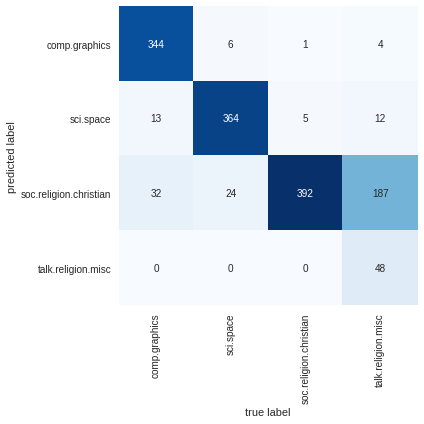

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

More interestingly, we can now use this classifier to predict, given some phrase, what general topic the phrase might be referring to.

We'll use the following quick convenience function:

In [21]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [22]:
predict_category('sending a payload to the ISS')

'sci.space'

In [23]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [24]:
predict_category('determining the screen resolution')

'comp.graphics'


Remember that this is nothing more sophisticated than a simple probability model for the (weighted) frequency of each word in the string; nevertheless, the result is striking.
Even a very naive algorithm, when used carefully and trained on a large set of high-dimensional data, can be surprisingly effective.

# Image Features

We've seen an approach to image classification that relies on the pixels themselves as features.
The problem is that the relationships between pixels are often more meaningful: for example, lines and gradients tell us much more about the content of the image, and are much more robust to lighting levels and other incidental differences between images.

For more complicated tasks involving images, it can be useful to derive other features that are more informative.
There are many approaches to this, but the one we'll demo here is known as *histograms of gradients* (HOG).
HOG involves the following steps:

1. Optionally prenormalize images. This leads to features that resist dependence on variations in illumination.
2. Convolve the image with two filters that are sensitive to horizontal and vertical brightness gradients. These capture edge, contour, and texture information.
3. Subdivide the image into cells of a predetermined size, and compute a histogram of the gradient orientations within each cell.
4. Normalize the histograms in each cell by comparing to the block of neighboring cells. This further suppresses the effect of illumination across the image.
5. Construct a one-dimensional feature vector from the information in each cell.

A fast HOG extractor is built into the scikit-image project, and we can try it out relatively quickly and visualize the oriented gradients within each cell:

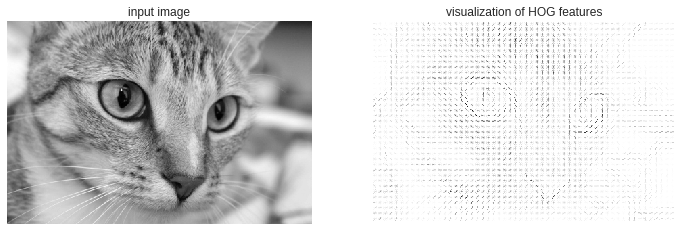

In [25]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualise=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis, cmap='binary')
ax[1].set_title('visualization of HOG features');

## HOG in Action: A Simple Face Detector

Using these HOG features, we can build up a simple facial detection algorithm with any scikit-learn estimator; here we will use a linear support vector machine (refer back to _Machine Learning with Scikit-Learn: Support Vector Machines_ if you need a refresher on this).
The steps are as follows:

1. Obtain a set of image thumbnails of faces to constitute "positive" training samples.
2. Obtain a set of image thumbnails of non-faces to constitute "negative" training samples.
3. Extract HOG features from these training samples.
4. Train a linear SVM classifier on these samples.
5. For an "unknown" image, pass a sliding window across the image, using the model to evaluate whether that window contains a face or not.
6. If detections overlap, combine them into a single window.

Let's go through these steps and try it out.

## 1. Obtain a Set of Positive Training Samples

Let's start by finding some positive training samples that show a variety of faces.
We have one easy set of data to work with—-the Labeled Faces in the Wild dataset, which can be downloaded by scikit-learn:

In [26]:

from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

This gives us a sample of 13,000 face images to use for training.

## 2. Obtain a Set of Negative Training Samples

Next, we need a set of similarly sized thumbnails that *do not* have a face in them.
One way to do this is to take any corpus of input images and extract thumbnails from them at a variety of scales.
Here we can use some of the images shipped with scikit-image, along with scikit-learn's ``PatchExtractor``:

In [27]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [28]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size, mode='constant')
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

We now have 30,000 suitable image patches that do not contain faces.
Let's take a look at a few of them to get an idea of what they look like:

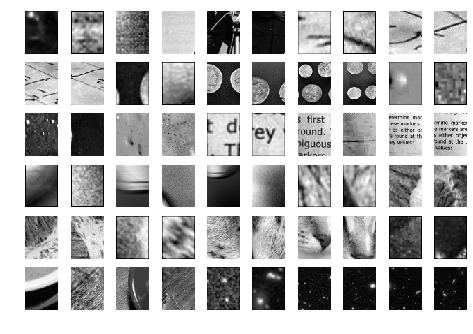

In [30]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

Our hope is that these would sufficiently cover the space of non-faces that our algorithm is likely to see.

## 3. Combine Sets and Extract HOG Features

Now that we have these positive samples and negative samples, we can combine them and compute HOG features.
This step takes a little while, because the HOG features involve a nontrivial computation for each image:

In [29]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [31]:
X_train.shape

(43233, 1215)

We are left with 43,000 training samples in 1,215 dimensions, and we now have our data in a form that we can feed into scikit-learn!

## 4. Training a Support Vector Machine

Next, we use the tools we have been exploring in this Oriole to create a classifier of thumbnail patches.
For such a high-dimensional binary classification task, a linear support vector machine is a good choice.
We will use scikit-learn's ``LinearSVC``, because in comparison to ``SVC``, it often has better scaling for a large number of samples.

First, though, let's use a simple Gaussian naive Bayes classifier to get a quick baseline:

In [32]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([ 0.94157241,  0.86850323,  0.94018458])

We see that on our training data, even a simple naive Bayes algorithm gets us upward of 90% accuracy.
Let's try the support vector machine, with a grid search over a few choices of the C parameter:

In [33]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

0.98630675641292531

In [34]:
grid.best_params_

{'C': 4.0}

Let's take the best estimator and retrain it on the full dataset:

In [35]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=4.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

This ``fit`` step finds our best estimator for detecting the presence of a face in a small image thumbnail.

## 5. Find Faces in a New Image

Now that we have this model in place, let's grab a new image and see how the model does.
We will use one portion of the astronaut image for simplicity (see a discussion of this below in "Caveats and Improvements," and run a sliding window over it and evaluate each patch:

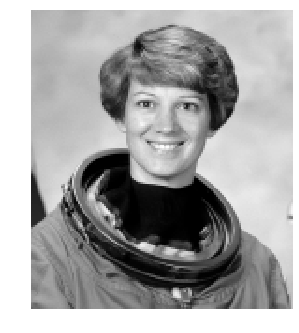

In [36]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5, mode='constant')
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

Next, let's create a window that iterates over patches of this image, and compute HOG features for each patch:

In [37]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch)
                        for patch in patches])
patches_hog.shape

(1911, 1215)

Finally, we can take these HOG-featured patches and use our model to evaluate whether each patch contains a face:

In [38]:
labels = model.predict(patches_hog)
labels.sum()

33.0

We see that out of nearly 2,000 patches, we have found 30 detections.
Let's use the information we have about these patches to show where they lie on our test image, drawing them as rectangles:

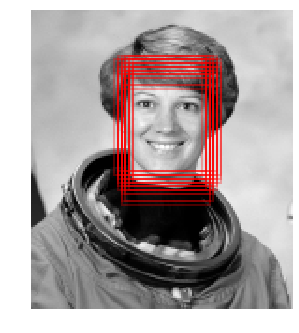

In [39]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

In [40]:
!tar chvfz notebook.tar.gz *

download_data.py
images/
images/sklearn_flowchart.png
images/tab-completion.png
images/iris.jpg
index.ipynb
requirements.txt
scikit_learn_data/
scikit_learn_data/lfw_home/
scikit_learn_data/lfw_home/pairsDevTest.txt
scikit_learn_data/lfw_home/pairs.txt
scikit_learn_data/lfw_home/joblib/
scikit_learn_data/lfw_home/joblib/sklearn/
scikit_learn_data/lfw_home/joblib/sklearn/datasets/
scikit_learn_data/lfw_home/joblib/sklearn/datasets/lfw/
scikit_learn_data/lfw_home/joblib/sklearn/datasets/lfw/_fetch_lfw_people/
scikit_learn_data/lfw_home/joblib/sklearn/datasets/lfw/_fetch_lfw_people/58fc17c11cd1880d8beabae2a181937d/
scikit_learn_data/lfw_home/joblib/sklearn/datasets/lfw/_fetch_lfw_people/58fc17c11cd1880d8beabae2a181937d/output.pkl
scikit_learn_data/lfw_home/joblib/sklearn/datasets/lfw/_fetch_lfw_people/58fc17c11cd1880d8beabae2a181937d/metadata.json
scikit_learn_data/lfw_home/joblib/sklearn/datasets/lfw/_fetch_lfw_people/func_code.py
scikit_learn_data/lfw_home/lfw_funneled/
scikit_learn_dat

scikit_learn_data/lfw_home/lfw_funneled/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0017.jpg
scikit_learn_data/lfw_home/lfw_funneled/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0007.jpg
scikit_learn_data/lfw_home/lfw_funneled/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0010.jpg
scikit_learn_data/lfw_home/lfw_funneled/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0021.jpg
scikit_learn_data/lfw_home/lfw_funneled/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0015.jpg
scikit_learn_data/lfw_home/lfw_funneled/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0014.jpg
scikit_learn_data/lfw_home/lfw_funneled/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0012.jpg
scikit_learn_data/lfw_home/lfw_funneled/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0009.jpg
scikit_learn_data/lfw_home/lfw_funneled/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0022.jpg
scikit_learn_data/lfw_home/lfw_funneled/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0016.jpg

scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Lopez/Jennifer_Lopez_0021.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Lopez/Jennifer_Lopez_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Lopez/Jennifer_Lopez_0017.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Lopez/Jennifer_Lopez_0008.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Lopez/Jennifer_Lopez_0009.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Lopez/Jennifer_Lopez_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Lopez/Jennifer_Lopez_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Lopez/Jennifer_Lopez_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Lopez/Jennifer_Lopez_0016.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Lopez/Jennifer_Lopez_0018.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Lopez/Jennifer_Lopez_0014.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Lopez/Jennifer_Lopez_0010.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Lop

scikit_learn_data/lfw_home/lfw_funneled/Kim_Dae-jung/
scikit_learn_data/lfw_home/lfw_funneled/Kim_Dae-jung/Kim_Dae-jung_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kim_Dae-jung/Kim_Dae-jung_0008.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kim_Dae-jung/Kim_Dae-jung_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kim_Dae-jung/Kim_Dae-jung_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kim_Dae-jung/Kim_Dae-jung_0007.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kim_Dae-jung/Kim_Dae-jung_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kim_Dae-jung/Kim_Dae-jung_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kim_Dae-jung/Kim_Dae-jung_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jean_Brumley/
scikit_learn_data/lfw_home/lfw_funneled/Jean_Brumley/Jean_Brumley_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jean_Brumley/Jean_Brumley_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Adisai_Bodharamik/
scikit_learn_data/lfw_home/lfw_funneled/Adisai_Bodharamik/Adisai_Bodharamik_0001.jp

scikit_learn_data/lfw_home/lfw_funneled/Norah_Jones/Norah_Jones_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Norah_Jones/Norah_Jones_0008.jpg
scikit_learn_data/lfw_home/lfw_funneled/Norah_Jones/Norah_Jones_0009.jpg
scikit_learn_data/lfw_home/lfw_funneled/Norah_Jones/Norah_Jones_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Norah_Jones/Norah_Jones_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Norah_Jones/Norah_Jones_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Norah_Jones/Norah_Jones_0014.jpg
scikit_learn_data/lfw_home/lfw_funneled/Norah_Jones/Norah_Jones_0013.jpg
scikit_learn_data/lfw_home/lfw_funneled/Norah_Jones/Norah_Jones_0011.jpg
scikit_learn_data/lfw_home/lfw_funneled/Norah_Jones/Norah_Jones_0015.jpg
scikit_learn_data/lfw_home/lfw_funneled/Norah_Jones/Norah_Jones_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Norah_Jones/Norah_Jones_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Norah_Jones/Norah_Jones_0012.jpg
scikit_learn_data/lfw_home/lfw_funneled/Karen_Clark

scikit_learn_data/lfw_home/lfw_funneled/Samira_Makhmalbaf/Samira_Makhmalbaf_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hideki_Sato/
scikit_learn_data/lfw_home/lfw_funneled/Hideki_Sato/Hideki_Sato_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jaouad_Gharib/
scikit_learn_data/lfw_home/lfw_funneled/Jaouad_Gharib/Jaouad_Gharib_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/John_Lawrence/
scikit_learn_data/lfw_home/lfw_funneled/John_Lawrence/John_Lawrence_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sylvie_Guillem/
scikit_learn_data/lfw_home/lfw_funneled/Sylvie_Guillem/Sylvie_Guillem_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mike_Holmgren/
scikit_learn_data/lfw_home/lfw_funneled/Mike_Holmgren/Mike_Holmgren_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mike_Holmgren/Mike_Holmgren_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Donna_Walker/
scikit_learn_data/lfw_home/lfw_funneled/Donna_Walker/Donna_Walker_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Christine_To

scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0184.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0070.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0229.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0330.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0393.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0237.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0269.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0309.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0261.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0285.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0089.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0478.jpg

scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0039.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0094.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0353.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0133.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0405.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0435.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0242.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0375.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0434.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0503.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0218.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0339.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0182.jpg

scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0238.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0163.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0290.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0324.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0469.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0528.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0207.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0097.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0186.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0277.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0306.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0365.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0317.jpg

scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0297.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0343.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0021.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0252.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0430.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0326.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0420.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0459.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0216.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0371.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0510.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0086.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_W_Bush/George_W_Bush_0129.jpg

scikit_learn_data/lfw_home/lfw_funneled/George_Lopez/George_Lopez_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_Lopez/George_Lopez_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_Lopez/George_Lopez_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Thomas_OBrien/
scikit_learn_data/lfw_home/lfw_funneled/Thomas_OBrien/Thomas_OBrien_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Thomas_OBrien/Thomas_OBrien_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Thomas_OBrien/Thomas_OBrien_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Thomas_OBrien/Thomas_OBrien_0008.jpg
scikit_learn_data/lfw_home/lfw_funneled/Thomas_OBrien/Thomas_OBrien_0009.jpg
scikit_learn_data/lfw_home/lfw_funneled/Thomas_OBrien/Thomas_OBrien_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Thomas_OBrien/Thomas_OBrien_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Thomas_OBrien/Thomas_OBrien_0007.jpg
scikit_learn_data/lfw_home/lfw_funneled/Thomas_OBrien/Thomas_OBrien_0003.jpg
scikit_learn_data/lfw_home/

scikit_learn_data/lfw_home/lfw_funneled/Roh_Moo-hyun/Roh_Moo-hyun_0021.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roh_Moo-hyun/Roh_Moo-hyun_0016.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roh_Moo-hyun/Roh_Moo-hyun_0031.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roh_Moo-hyun/Roh_Moo-hyun_0028.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roh_Moo-hyun/Roh_Moo-hyun_0018.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roh_Moo-hyun/Roh_Moo-hyun_0030.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roh_Moo-hyun/Roh_Moo-hyun_0019.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roh_Moo-hyun/Roh_Moo-hyun_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roh_Moo-hyun/Roh_Moo-hyun_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roh_Moo-hyun/Roh_Moo-hyun_0024.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roh_Moo-hyun/Roh_Moo-hyun_0014.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roh_Moo-hyun/Roh_Moo-hyun_0010.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roh_Moo-hyun/Roh_Moo-hyun_0008.jpg
scikit_learn_data/lfw_hom

scikit_learn_data/lfw_home/lfw_funneled/Dennis_Kucinich/Dennis_Kucinich_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Javier_Zanetti/
scikit_learn_data/lfw_home/lfw_funneled/Javier_Zanetti/Javier_Zanetti_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Clemente_de_la_Vega/
scikit_learn_data/lfw_home/lfw_funneled/Clemente_de_la_Vega/Clemente_de_la_Vega_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sheila_Fraser/
scikit_learn_data/lfw_home/lfw_funneled/Sheila_Fraser/Sheila_Fraser_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sheila_Fraser/Sheila_Fraser_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Shigeo_Nagashima/
scikit_learn_data/lfw_home/lfw_funneled/Shigeo_Nagashima/Shigeo_Nagashima_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Steven_Van_Zandt/
scikit_learn_data/lfw_home/lfw_funneled/Steven_Van_Zandt/Steven_Van_Zandt_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tino_Martinez/
scikit_learn_data/lfw_home/lfw_funneled/Tino_Martinez/Tino_Martinez_0001.jpg
scikit_lear

scikit_learn_data/lfw_home/lfw_funneled/Kwon_Young-gil/
scikit_learn_data/lfw_home/lfw_funneled/Kwon_Young-gil/Kwon_Young-gil_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mstislav_Rostropovich/
scikit_learn_data/lfw_home/lfw_funneled/Mstislav_Rostropovich/Mstislav_Rostropovich_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Robert_Witt/
scikit_learn_data/lfw_home/lfw_funneled/Robert_Witt/Robert_Witt_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Robert_Witt/Robert_Witt_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Akhmed_Zakayev/
scikit_learn_data/lfw_home/lfw_funneled/Akhmed_Zakayev/Akhmed_Zakayev_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Akhmed_Zakayev/Akhmed_Zakayev_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Akhmed_Zakayev/Akhmed_Zakayev_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Billy_Crystal/
scikit_learn_data/lfw_home/lfw_funneled/Billy_Crystal/Billy_Crystal_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Billy_Crystal/Billy_Crystal_0004.jpg
scikit_l

scikit_learn_data/lfw_home/lfw_funneled/Ralph_Sampson/
scikit_learn_data/lfw_home/lfw_funneled/Ralph_Sampson/Ralph_Sampson_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Abraham_Foxman/
scikit_learn_data/lfw_home/lfw_funneled/Abraham_Foxman/Abraham_Foxman_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gerrit_Zalm/
scikit_learn_data/lfw_home/lfw_funneled/Gerrit_Zalm/Gerrit_Zalm_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jimmy_Carter/
scikit_learn_data/lfw_home/lfw_funneled/Jimmy_Carter/Jimmy_Carter_0009.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jimmy_Carter/Jimmy_Carter_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jimmy_Carter/Jimmy_Carter_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jimmy_Carter/Jimmy_Carter_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jimmy_Carter/Jimmy_Carter_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jimmy_Carter/Jimmy_Carter_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jimmy_Carter/Jimmy_Carter_0005.jpg
scikit_learn_data/lfw_home/l

scikit_learn_data/lfw_home/lfw_funneled/Paula_Radcliffe/Paula_Radcliffe_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paula_Radcliffe/Paula_Radcliffe_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ronald_White/
scikit_learn_data/lfw_home/lfw_funneled/Ronald_White/Ronald_White_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jim_Sterk/
scikit_learn_data/lfw_home/lfw_funneled/Jim_Sterk/Jim_Sterk_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Shanna_Zolman/
scikit_learn_data/lfw_home/lfw_funneled/Shanna_Zolman/Shanna_Zolman_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gary_Sayler/
scikit_learn_data/lfw_home/lfw_funneled/Gary_Sayler/Gary_Sayler_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Claire_Leger/
scikit_learn_data/lfw_home/lfw_funneled/Claire_Leger/Claire_Leger_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Claire_Leger/Claire_Leger_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/John_Burkett/
scikit_learn_data/lfw_home/lfw_funneled/John_Burkett/John_Burkett_0001.jp

scikit_learn_data/lfw_home/lfw_funneled/Robby_Ginepri/Robby_Ginepri_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Peter_Ueberroth/
scikit_learn_data/lfw_home/lfw_funneled/Peter_Ueberroth/Peter_Ueberroth_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Anthony_Pico/
scikit_learn_data/lfw_home/lfw_funneled/Anthony_Pico/Anthony_Pico_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mohammad_Khatami/
scikit_learn_data/lfw_home/lfw_funneled/Mohammad_Khatami/Mohammad_Khatami_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mohammad_Khatami/Mohammad_Khatami_0009.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mohammad_Khatami/Mohammad_Khatami_0007.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mohammad_Khatami/Mohammad_Khatami_0008.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mohammad_Khatami/Mohammad_Khatami_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mohammad_Khatami/Mohammad_Khatami_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mohammad_Khatami/Mohammad_Khatami_0001.jpg
scikit_learn_data

scikit_learn_data/lfw_home/lfw_funneled/Cristian_Barros/
scikit_learn_data/lfw_home/lfw_funneled/Cristian_Barros/Cristian_Barros_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/James_Spalding/
scikit_learn_data/lfw_home/lfw_funneled/James_Spalding/James_Spalding_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Desmon_Farmer/
scikit_learn_data/lfw_home/lfw_funneled/Desmon_Farmer/Desmon_Farmer_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Freda_Black/
scikit_learn_data/lfw_home/lfw_funneled/Freda_Black/Freda_Black_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Vladimir_Putin/
scikit_learn_data/lfw_home/lfw_funneled/Vladimir_Putin/Vladimir_Putin_0010.jpg
scikit_learn_data/lfw_home/lfw_funneled/Vladimir_Putin/Vladimir_Putin_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Vladimir_Putin/Vladimir_Putin_0029.jpg
scikit_learn_data/lfw_home/lfw_funneled/Vladimir_Putin/Vladimir_Putin_0033.jpg
scikit_learn_data/lfw_home/lfw_funneled/Vladimir_Putin/Vladimir_Putin_0015.jpg
scikit_learn_data/

scikit_learn_data/lfw_home/lfw_funneled/Sergey_Lavrov/Sergey_Lavrov_0008.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sergey_Lavrov/Sergey_Lavrov_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sergey_Lavrov/Sergey_Lavrov_0011.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sergey_Lavrov/Sergey_Lavrov_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sergey_Lavrov/Sergey_Lavrov_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sergey_Lavrov/Sergey_Lavrov_0007.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sergey_Lavrov/Sergey_Lavrov_0010.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sergey_Lavrov/Sergey_Lavrov_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sergey_Lavrov/Sergey_Lavrov_0009.jpg
scikit_learn_data/lfw_home/lfw_funneled/John_Travolta/
scikit_learn_data/lfw_home/lfw_funneled/John_Travolta/John_Travolta_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/John_Travolta/John_Travolta_0007.jpg
scikit_learn_data/lfw_home/lfw_funneled/John_Travolta/John_Travolta_0001.jpg
scikit_learn_data/lfw

scikit_learn_data/lfw_home/lfw_funneled/Frank_Lautenberg/
scikit_learn_data/lfw_home/lfw_funneled/Frank_Lautenberg/Frank_Lautenberg_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Frank_Lautenberg/Frank_Lautenberg_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Steve_Mariucci/
scikit_learn_data/lfw_home/lfw_funneled/Steve_Mariucci/Steve_Mariucci_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Steve_Mariucci/Steve_Mariucci_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Steve_Mariucci/Steve_Mariucci_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Parthiv_Patel/
scikit_learn_data/lfw_home/lfw_funneled/Parthiv_Patel/Parthiv_Patel_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Elgin_Baylor/
scikit_learn_data/lfw_home/lfw_funneled/Elgin_Baylor/Elgin_Baylor_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gene_Robinson/
scikit_learn_data/lfw_home/lfw_funneled/Gene_Robinson/Gene_Robinson_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gene_Robinson/Gene_Robinson_0002.jpg
scikit_learn_

scikit_learn_data/lfw_home/lfw_funneled/Anthony_Garotinho/
scikit_learn_data/lfw_home/lfw_funneled/Anthony_Garotinho/Anthony_Garotinho_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Anthony_Rackauckas/
scikit_learn_data/lfw_home/lfw_funneled/Anthony_Rackauckas/Anthony_Rackauckas_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Shigeru_Ishiba/
scikit_learn_data/lfw_home/lfw_funneled/Shigeru_Ishiba/Shigeru_Ishiba_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Nick_Turner/
scikit_learn_data/lfw_home/lfw_funneled/Nick_Turner/Nick_Turner_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Joe_Leonard/
scikit_learn_data/lfw_home/lfw_funneled/Joe_Leonard/Joe_Leonard_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Astou_Ndiaye-Diatta/
scikit_learn_data/lfw_home/lfw_funneled/Astou_Ndiaye-Diatta/Astou_Ndiaye-Diatta_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jack_Welch/
scikit_learn_data/lfw_home/lfw_funneled/Jack_Welch/Jack_Welch_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mahmoud_A

scikit_learn_data/lfw_home/lfw_funneled/Silvie_Cabero/
scikit_learn_data/lfw_home/lfw_funneled/Silvie_Cabero/Silvie_Cabero_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Robert_Schuller/
scikit_learn_data/lfw_home/lfw_funneled/Robert_Schuller/Robert_Schuller_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mike_Webster/
scikit_learn_data/lfw_home/lfw_funneled/Mike_Webster/Mike_Webster_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/John_Nash/
scikit_learn_data/lfw_home/lfw_funneled/John_Nash/John_Nash_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ashley_Judd/
scikit_learn_data/lfw_home/lfw_funneled/Ashley_Judd/Ashley_Judd_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gong_Li/
scikit_learn_data/lfw_home/lfw_funneled/Gong_Li/Gong_Li_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/David_Ballantyne/
scikit_learn_data/lfw_home/lfw_funneled/David_Ballantyne/David_Ballantyne_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Anita_DeFrantz/
scikit_learn_data/lfw_home/lfw_funneled/Anit

scikit_learn_data/lfw_home/lfw_funneled/Ariel_Sharon/Ariel_Sharon_0015.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ariel_Sharon/Ariel_Sharon_0010.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ariel_Sharon/Ariel_Sharon_0072.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ariel_Sharon/Ariel_Sharon_0046.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ariel_Sharon/Ariel_Sharon_0049.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ariel_Sharon/Ariel_Sharon_0039.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ariel_Sharon/Ariel_Sharon_0019.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ariel_Sharon/Ariel_Sharon_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ariel_Sharon/Ariel_Sharon_0059.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ariel_Sharon/Ariel_Sharon_0008.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ariel_Sharon/Ariel_Sharon_0067.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ariel_Sharon/Ariel_Sharon_0024.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ariel_Sharon/Ariel_Sharon_0063.jpg
scikit_learn_data/lfw_hom

scikit_learn_data/lfw_home/lfw_funneled/Bill_King/
scikit_learn_data/lfw_home/lfw_funneled/Bill_King/Bill_King_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Charlotte_Church/
scikit_learn_data/lfw_home/lfw_funneled/Charlotte_Church/Charlotte_Church_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Juljia_Vysotskij/
scikit_learn_data/lfw_home/lfw_funneled/Juljia_Vysotskij/Juljia_Vysotskij_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Michael_DeMinico/
scikit_learn_data/lfw_home/lfw_funneled/Michael_DeMinico/Michael_DeMinico_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roman_Polanski/
scikit_learn_data/lfw_home/lfw_funneled/Roman_Polanski/Roman_Polanski_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roman_Polanski/Roman_Polanski_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roman_Polanski/Roman_Polanski_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roman_Polanski/Roman_Polanski_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roman_Polanski/Roman_Polanski_0005.jpg
scikit

scikit_learn_data/lfw_home/lfw_funneled/Alejandro_Toledo/Alejandro_Toledo_0039.jpg
scikit_learn_data/lfw_home/lfw_funneled/Alejandro_Toledo/Alejandro_Toledo_0019.jpg
scikit_learn_data/lfw_home/lfw_funneled/Alejandro_Toledo/Alejandro_Toledo_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Alejandro_Toledo/Alejandro_Toledo_0022.jpg
scikit_learn_data/lfw_home/lfw_funneled/Alejandro_Toledo/Alejandro_Toledo_0021.jpg
scikit_learn_data/lfw_home/lfw_funneled/Alejandro_Toledo/Alejandro_Toledo_0037.jpg
scikit_learn_data/lfw_home/lfw_funneled/Alejandro_Toledo/Alejandro_Toledo_0020.jpg
scikit_learn_data/lfw_home/lfw_funneled/Alejandro_Toledo/Alejandro_Toledo_0036.jpg
scikit_learn_data/lfw_home/lfw_funneled/Alejandro_Toledo/Alejandro_Toledo_0033.jpg
scikit_learn_data/lfw_home/lfw_funneled/Alejandro_Toledo/Alejandro_Toledo_0011.jpg
scikit_learn_data/lfw_home/lfw_funneled/Alejandro_Toledo/Alejandro_Toledo_0023.jpg
scikit_learn_data/lfw_home/lfw_funneled/Alejandro_Toledo/Alejandro_Toledo_0028.jpg
scik

scikit_learn_data/lfw_home/lfw_funneled/Kim_Jong-Il/
scikit_learn_data/lfw_home/lfw_funneled/Kim_Jong-Il/Kim_Jong-Il_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kim_Jong-Il/Kim_Jong-Il_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kim_Jong-Il/Kim_Jong-Il_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kim_Jong-Il/Kim_Jong-Il_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tom_Coverdale/
scikit_learn_data/lfw_home/lfw_funneled/Tom_Coverdale/Tom_Coverdale_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tom_Coverdale/Tom_Coverdale_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jan_De_Bont/
scikit_learn_data/lfw_home/lfw_funneled/Jan_De_Bont/Jan_De_Bont_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Shingo_Katayama/
scikit_learn_data/lfw_home/lfw_funneled/Shingo_Katayama/Shingo_Katayama_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Marcos_Daniel_Jimenez/
scikit_learn_data/lfw_home/lfw_funneled/Marcos_Daniel_Jimenez/Marcos_Daniel_Jimenez_0001.jpg
scikit_learn_data/lfw_home

scikit_learn_data/lfw_home/lfw_funneled/Scott_Peterson/Scott_Peterson_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Scott_Peterson/Scott_Peterson_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Scott_Peterson/Scott_Peterson_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Scott_Peterson/Scott_Peterson_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ralph_Lauren/
scikit_learn_data/lfw_home/lfw_funneled/Ralph_Lauren/Ralph_Lauren_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ralph_Lauren/Ralph_Lauren_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Romario_Farias/
scikit_learn_data/lfw_home/lfw_funneled/Romario_Farias/Romario_Farias_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jim_Hardin/
scikit_learn_data/lfw_home/lfw_funneled/Jim_Hardin/Jim_Hardin_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Larry_Ellison/
scikit_learn_data/lfw_home/lfw_funneled/Larry_Ellison/Larry_Ellison_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Larry_Ellison/Larry_Ellison_0002.jpg
scikit_learn_

scikit_learn_data/lfw_home/lfw_funneled/Stephen_Crampton/
scikit_learn_data/lfw_home/lfw_funneled/Stephen_Crampton/Stephen_Crampton_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Russell_Crowe/
scikit_learn_data/lfw_home/lfw_funneled/Russell_Crowe/Russell_Crowe_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Russell_Crowe/Russell_Crowe_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Billy_Bob_Thornton/
scikit_learn_data/lfw_home/lfw_funneled/Billy_Bob_Thornton/Billy_Bob_Thornton_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Marlene_Weingartner/
scikit_learn_data/lfw_home/lfw_funneled/Marlene_Weingartner/Marlene_Weingartner_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Marlene_Weingartner/Marlene_Weingartner_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Rose_Linkins/
scikit_learn_data/lfw_home/lfw_funneled/Rose_Linkins/Rose_Linkins_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Allan_Kemakeza/
scikit_learn_data/lfw_home/lfw_funneled/Allan_Kemakeza/Allan_Kemakeza_0001.jpg


scikit_learn_data/lfw_home/lfw_funneled/Mick_Jagger/Mick_Jagger_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mick_Jagger/Mick_Jagger_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mick_Jagger/Mick_Jagger_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mick_Jagger/Mick_Jagger_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Freddy_Vasques_Kinchokpe/
scikit_learn_data/lfw_home/lfw_funneled/Freddy_Vasques_Kinchokpe/Freddy_Vasques_Kinchokpe_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roman_Coppola/
scikit_learn_data/lfw_home/lfw_funneled/Roman_Coppola/Roman_Coppola_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Queen_Rania/
scikit_learn_data/lfw_home/lfw_funneled/Queen_Rania/Queen_Rania_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Queen_Rania/Queen_Rania_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Queen_Rania/Queen_Rania_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Queen_Rania/Queen_Rania_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Queen_Rania/Queen_Rania_00

scikit_learn_data/lfw_home/lfw_funneled/Arantxa_Sanchez-Vicario/
scikit_learn_data/lfw_home/lfw_funneled/Arantxa_Sanchez-Vicario/Arantxa_Sanchez-Vicario_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Arantxa_Sanchez-Vicario/Arantxa_Sanchez-Vicario_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/James_Layug/
scikit_learn_data/lfw_home/lfw_funneled/James_Layug/James_Layug_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mara_Georges/
scikit_learn_data/lfw_home/lfw_funneled/Mara_Georges/Mara_Georges_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jeremy_Wotherspoon/
scikit_learn_data/lfw_home/lfw_funneled/Jeremy_Wotherspoon/Jeremy_Wotherspoon_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Vincent_Cianci_Jr/
scikit_learn_data/lfw_home/lfw_funneled/Vincent_Cianci_Jr/Vincent_Cianci_Jr_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Robert_Zoellick/
scikit_learn_data/lfw_home/lfw_funneled/Robert_Zoellick/Robert_Zoellick_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Robert_Zoellick/R

scikit_learn_data/lfw_home/lfw_funneled/Al_Davis/Al_Davis_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Goh_Kun/
scikit_learn_data/lfw_home/lfw_funneled/Goh_Kun/Goh_Kun_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Goh_Kun/Goh_Kun_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Queen_Latifah/
scikit_learn_data/lfw_home/lfw_funneled/Queen_Latifah/Queen_Latifah_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Queen_Latifah/Queen_Latifah_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Queen_Latifah/Queen_Latifah_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Queen_Latifah/Queen_Latifah_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Li_Ka-shing/
scikit_learn_data/lfw_home/lfw_funneled/Li_Ka-shing/Li_Ka-shing_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Norodom_Chakrapong/
scikit_learn_data/lfw_home/lfw_funneled/Norodom_Chakrapong/Norodom_Chakrapong_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jason_Sorens/
scikit_learn_data/lfw_home/lfw_funneled/Jason_Sorens/Jason_Soren

scikit_learn_data/lfw_home/lfw_funneled/Michael_Schumacher/Michael_Schumacher_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paula_Dobriansky/
scikit_learn_data/lfw_home/lfw_funneled/Paula_Dobriansky/Paula_Dobriansky_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Aniston/
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Aniston/Jennifer_Aniston_0008.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Aniston/Jennifer_Aniston_0016.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Aniston/Jennifer_Aniston_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Aniston/Jennifer_Aniston_0013.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Aniston/Jennifer_Aniston_0017.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Aniston/Jennifer_Aniston_0019.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Aniston/Jennifer_Aniston_0012.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_Aniston/Jennifer_Aniston_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jennifer_A

scikit_learn_data/lfw_home/lfw_funneled/Tang_Jiaxuan/Tang_Jiaxuan_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tang_Jiaxuan/Tang_Jiaxuan_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tang_Jiaxuan/Tang_Jiaxuan_0009.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tang_Jiaxuan/Tang_Jiaxuan_0007.jpg
scikit_learn_data/lfw_home/lfw_funneled/Betsy_Smith/
scikit_learn_data/lfw_home/lfw_funneled/Betsy_Smith/Betsy_Smith_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Betsy_Smith/Betsy_Smith_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Teri_ORourke/
scikit_learn_data/lfw_home/lfw_funneled/Teri_ORourke/Teri_ORourke_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Alberta_Lee/
scikit_learn_data/lfw_home/lfw_funneled/Alberta_Lee/Alberta_Lee_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Steffi_Graf/
scikit_learn_data/lfw_home/lfw_funneled/Steffi_Graf/Steffi_Graf_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Steffi_Graf/Steffi_Graf_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Steffi_

scikit_learn_data/lfw_home/lfw_funneled/Li_Peng/Li_Peng_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Li_Peng/Li_Peng_0008.jpg
scikit_learn_data/lfw_home/lfw_funneled/Li_Peng/Li_Peng_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Li_Peng/Li_Peng_0007.jpg
scikit_learn_data/lfw_home/lfw_funneled/Li_Peng/Li_Peng_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Li_Peng/Li_Peng_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Li_Peng/Li_Peng_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Li_Peng/Li_Peng_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Stan_Kasten/
scikit_learn_data/lfw_home/lfw_funneled/Stan_Kasten/Stan_Kasten_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_Papandreou/
scikit_learn_data/lfw_home/lfw_funneled/George_Papandreou/George_Papandreou_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_Papandreou/George_Papandreou_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_Papandreou/George_Papandreou_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/

scikit_learn_data/lfw_home/lfw_funneled/Jodie_Foster/
scikit_learn_data/lfw_home/lfw_funneled/Jodie_Foster/Jodie_Foster_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jodie_Foster/Jodie_Foster_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jodie_Foster/Jodie_Foster_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mickey_Gilley/
scikit_learn_data/lfw_home/lfw_funneled/Mickey_Gilley/Mickey_Gilley_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_Galloway/
scikit_learn_data/lfw_home/lfw_funneled/George_Galloway/George_Galloway_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_Galloway/George_Galloway_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_Galloway/George_Galloway_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_Galloway/George_Galloway_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Percy_Gibson/
scikit_learn_data/lfw_home/lfw_funneled/Percy_Gibson/Percy_Gibson_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Prem_Kumar_Nair/
scikit_learn_data/lfw_

scikit_learn_data/lfw_home/lfw_funneled/Julianne_Moore/Julianne_Moore_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Julianne_Moore/Julianne_Moore_0018.jpg
scikit_learn_data/lfw_home/lfw_funneled/Julianne_Moore/Julianne_Moore_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Heather_Willson/
scikit_learn_data/lfw_home/lfw_funneled/Heather_Willson/Heather_Willson_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sachin_Tendulkar/
scikit_learn_data/lfw_home/lfw_funneled/Sachin_Tendulkar/Sachin_Tendulkar_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Lee_Hyung-taik/
scikit_learn_data/lfw_home/lfw_funneled/Lee_Hyung-taik/Lee_Hyung-taik_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mark_Mishkin/
scikit_learn_data/lfw_home/lfw_funneled/Mark_Mishkin/Mark_Mishkin_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gene_Sauers/
scikit_learn_data/lfw_home/lfw_funneled/Gene_Sauers/Gene_Sauers_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Boris_Trajkovski/
scikit_learn_data/lfw_home/lfw_funne

scikit_learn_data/lfw_home/lfw_funneled/Begum_Khaleda_Zia/Begum_Khaleda_Zia_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Daniel_Bruehl/
scikit_learn_data/lfw_home/lfw_funneled/Daniel_Bruehl/Daniel_Bruehl_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ibrahim_Haddad/
scikit_learn_data/lfw_home/lfw_funneled/Ibrahim_Haddad/Ibrahim_Haddad_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kristen_Rivera/
scikit_learn_data/lfw_home/lfw_funneled/Kristen_Rivera/Kristen_Rivera_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Yishan_Zhang/
scikit_learn_data/lfw_home/lfw_funneled/Yishan_Zhang/Yishan_Zhang_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Pham_Sy_Chien/
scikit_learn_data/lfw_home/lfw_funneled/Pham_Sy_Chien/Pham_Sy_Chien_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Chuck_Hagel/
scikit_learn_data/lfw_home/lfw_funneled/Chuck_Hagel/Chuck_Hagel_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Geraldine_Chaplin/
scikit_learn_data/lfw_home/lfw_funneled/Geraldine_Chaplin/Geraldine

scikit_learn_data/lfw_home/lfw_funneled/John_Leguizamo/John_Leguizamo_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/William_Swor/
scikit_learn_data/lfw_home/lfw_funneled/William_Swor/William_Swor_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Omar_Sharif/
scikit_learn_data/lfw_home/lfw_funneled/Omar_Sharif/Omar_Sharif_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Omar_Sharif/Omar_Sharif_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Omar_Sharif/Omar_Sharif_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Omar_Sharif/Omar_Sharif_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Peter_Camejo/
scikit_learn_data/lfw_home/lfw_funneled/Peter_Camejo/Peter_Camejo_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ray_Allen/
scikit_learn_data/lfw_home/lfw_funneled/Ray_Allen/Ray_Allen_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ray_Allen/Ray_Allen_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ray_Allen/Ray_Allen_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Margaret_Hasley/
sci

scikit_learn_data/lfw_home/lfw_funneled/Jean-Pierre_Raffarin/
scikit_learn_data/lfw_home/lfw_funneled/Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0007.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Thierry_Mariani/
scikit_learn_data/lfw_home/lfw_funneled/Thierry_Mariani/Thierry_Mariani_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Millicent_Martin/
scikit_learn_data/lfw_home/lfw_funneled/Millicent_Martin/Millicent_Martin_0001.jpg
scikit_learn_data/lfw_

scikit_learn_data/lfw_home/lfw_funneled/Renee_Zellweger/Renee_Zellweger_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Renee_Zellweger/Renee_Zellweger_0015.jpg
scikit_learn_data/lfw_home/lfw_funneled/Renee_Zellweger/Renee_Zellweger_0017.jpg
scikit_learn_data/lfw_home/lfw_funneled/Renee_Zellweger/Renee_Zellweger_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Robert_Towne/
scikit_learn_data/lfw_home/lfw_funneled/Robert_Towne/Robert_Towne_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Dita_Von_Tesse/
scikit_learn_data/lfw_home/lfw_funneled/Dita_Von_Tesse/Dita_Von_Tesse_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ray_Wasden/
scikit_learn_data/lfw_home/lfw_funneled/Ray_Wasden/Ray_Wasden_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tayshaun_Prince/
scikit_learn_data/lfw_home/lfw_funneled/Tayshaun_Prince/Tayshaun_Prince_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Simona_Hradil/
scikit_learn_data/lfw_home/lfw_funneled/Simona_Hradil/Simona_Hradil_0001.jpg
scikit_learn_data/l

scikit_learn_data/lfw_home/lfw_funneled/Thomas_Haeggstroem/Thomas_Haeggstroem_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Marcelo_Salas/
scikit_learn_data/lfw_home/lfw_funneled/Marcelo_Salas/Marcelo_Salas_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Marcelo_Salas/Marcelo_Salas_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Marcelo_Salas/Marcelo_Salas_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Diego_Armando_Maradona/
scikit_learn_data/lfw_home/lfw_funneled/Diego_Armando_Maradona/Diego_Armando_Maradona_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kurt_Tanabe/
scikit_learn_data/lfw_home/lfw_funneled/Kurt_Tanabe/Kurt_Tanabe_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Derek_Parra/
scikit_learn_data/lfw_home/lfw_funneled/Derek_Parra/Derek_Parra_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Nur_Jaafar/
scikit_learn_data/lfw_home/lfw_funneled/Nur_Jaafar/Nur_Jaafar_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jaymon_Crabb/
scikit_learn_data/lfw_home/lfw_funneled

scikit_learn_data/lfw_home/lfw_funneled/William_Rosenberg/
scikit_learn_data/lfw_home/lfw_funneled/William_Rosenberg/William_Rosenberg_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Greg_Gilbert/
scikit_learn_data/lfw_home/lfw_funneled/Greg_Gilbert/Greg_Gilbert_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Greg_Gilbert/Greg_Gilbert_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Martin_Hoellwarth/
scikit_learn_data/lfw_home/lfw_funneled/Martin_Hoellwarth/Martin_Hoellwarth_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Martin_Hoellwarth/Martin_Hoellwarth_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Robert_Bullock/
scikit_learn_data/lfw_home/lfw_funneled/Robert_Bullock/Robert_Bullock_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Robert_Bullock/Robert_Bullock_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Vladimir_Ustinov/
scikit_learn_data/lfw_home/lfw_funneled/Vladimir_Ustinov/Vladimir_Ustinov_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jose_Sarney/
scikit_learn_da

scikit_learn_data/lfw_home/lfw_funneled/Roberto_Carlos/
scikit_learn_data/lfw_home/lfw_funneled/Roberto_Carlos/Roberto_Carlos_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roberto_Carlos/Roberto_Carlos_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roberto_Carlos/Roberto_Carlos_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roberto_Carlos/Roberto_Carlos_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jens_Lehmann/
scikit_learn_data/lfw_home/lfw_funneled/Jens_Lehmann/Jens_Lehmann_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Joey_Buttafuoco/
scikit_learn_data/lfw_home/lfw_funneled/Joey_Buttafuoco/Joey_Buttafuoco_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jon_Voight/
scikit_learn_data/lfw_home/lfw_funneled/Jon_Voight/Jon_Voight_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jon_Voight/Jon_Voight_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jon_Voight/Jon_Voight_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ingrid_Betancourt/
scikit_learn_data/lfw_home/lfw_funnel

scikit_learn_data/lfw_home/lfw_funneled/Richard_Armitage/Richard_Armitage_0008.jpg
scikit_learn_data/lfw_home/lfw_funneled/Erskine_Bowles/
scikit_learn_data/lfw_home/lfw_funneled/Erskine_Bowles/Erskine_Bowles_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paul_Kagame/
scikit_learn_data/lfw_home/lfw_funneled/Paul_Kagame/Paul_Kagame_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paul_Kagame/Paul_Kagame_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paul_Sarbanes/
scikit_learn_data/lfw_home/lfw_funneled/Paul_Sarbanes/Paul_Sarbanes_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paul_Sarbanes/Paul_Sarbanes_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paul_Sarbanes/Paul_Sarbanes_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ali_Mohammed_Maher/
scikit_learn_data/lfw_home/lfw_funneled/Ali_Mohammed_Maher/Ali_Mohammed_Maher_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paddy_Long/
scikit_learn_data/lfw_home/lfw_funneled/Paddy_Long/Paddy_Long_0001.jpg
scikit_learn_data/lfw_home/

scikit_learn_data/lfw_home/lfw_funneled/Matthew_During/
scikit_learn_data/lfw_home/lfw_funneled/Matthew_During/Matthew_During_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Artieas_Shanks/
scikit_learn_data/lfw_home/lfw_funneled/Artieas_Shanks/Artieas_Shanks_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Alexa_Vega/
scikit_learn_data/lfw_home/lfw_funneled/Alexa_Vega/Alexa_Vega_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tim_Lobinger/
scikit_learn_data/lfw_home/lfw_funneled/Tim_Lobinger/Tim_Lobinger_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Pedro_Duque/
scikit_learn_data/lfw_home/lfw_funneled/Pedro_Duque/Pedro_Duque_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paul_Otellini/
scikit_learn_data/lfw_home/lfw_funneled/Paul_Otellini/Paul_Otellini_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Khader_Rashid_Rahim/
scikit_learn_data/lfw_home/lfw_funneled/Khader_Rashid_Rahim/Khader_Rashid_Rahim_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Cherie_Blair/
scikit_learn_dat

scikit_learn_data/lfw_home/lfw_funneled/Eric_Lindros/Eric_Lindros_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roberto_Tovar/
scikit_learn_data/lfw_home/lfw_funneled/Roberto_Tovar/Roberto_Tovar_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hasan_Wirayuda/
scikit_learn_data/lfw_home/lfw_funneled/Hasan_Wirayuda/Hasan_Wirayuda_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Nila_Ferran/
scikit_learn_data/lfw_home/lfw_funneled/Nila_Ferran/Nila_Ferran_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Armando_Calderon_Sol/
scikit_learn_data/lfw_home/lfw_funneled/Armando_Calderon_Sol/Armando_Calderon_Sol_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jamie_Carey/
scikit_learn_data/lfw_home/lfw_funneled/Jamie_Carey/Jamie_Carey_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/pairs_04.txt
scikit_learn_data/lfw_home/lfw_funneled/Lydia_Shum/
scikit_learn_data/lfw_home/lfw_funneled/Lydia_Shum/Lydia_Shum_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kultida_Woods/
scikit_learn_data/lfw_

scikit_learn_data/lfw_home/lfw_funneled/Jake_Gyllenhaal/
scikit_learn_data/lfw_home/lfw_funneled/Jake_Gyllenhaal/Jake_Gyllenhaal_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jake_Gyllenhaal/Jake_Gyllenhaal_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jake_Gyllenhaal/Jake_Gyllenhaal_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jake_Gyllenhaal/Jake_Gyllenhaal_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jake_Gyllenhaal/Jake_Gyllenhaal_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Nicholas_Byron/
scikit_learn_data/lfw_home/lfw_funneled/Nicholas_Byron/Nicholas_Byron_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Nicholas_Byron/Nicholas_Byron_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Richard_Virenque/
scikit_learn_data/lfw_home/lfw_funneled/Richard_Virenque/Richard_Virenque_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Richard_Virenque/Richard_Virenque_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Richard_Virenque/Richard_Virenque_0004.jpg
scikit_learn_data

scikit_learn_data/lfw_home/lfw_funneled/Kenneth_Brill/
scikit_learn_data/lfw_home/lfw_funneled/Kenneth_Brill/Kenneth_Brill_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Christian_Gimenez/
scikit_learn_data/lfw_home/lfw_funneled/Christian_Gimenez/Christian_Gimenez_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Abdul_Rahman/
scikit_learn_data/lfw_home/lfw_funneled/Abdul_Rahman/Abdul_Rahman_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Michael_Chertoff/
scikit_learn_data/lfw_home/lfw_funneled/Michael_Chertoff/Michael_Chertoff_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Bobby_Robson/
scikit_learn_data/lfw_home/lfw_funneled/Bobby_Robson/Bobby_Robson_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Bobby_Robson/Bobby_Robson_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Darcy_Regier/
scikit_learn_data/lfw_home/lfw_funneled/Darcy_Regier/Darcy_Regier_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ann_Morgan/
scikit_learn_data/lfw_home/lfw_funneled/Ann_Morgan/Ann_Morgan_0001.jp

scikit_learn_data/lfw_home/lfw_funneled/Christian_Lirette/
scikit_learn_data/lfw_home/lfw_funneled/Christian_Lirette/Christian_Lirette_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Juan_Sanchez/
scikit_learn_data/lfw_home/lfw_funneled/Juan_Sanchez/Juan_Sanchez_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Takashi_Yamamoto/
scikit_learn_data/lfw_home/lfw_funneled/Takashi_Yamamoto/Takashi_Yamamoto_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Chang_Jae_On/
scikit_learn_data/lfw_home/lfw_funneled/Chang_Jae_On/Chang_Jae_On_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Todd_Robbins/
scikit_learn_data/lfw_home/lfw_funneled/Todd_Robbins/Todd_Robbins_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/David_Chase/
scikit_learn_data/lfw_home/lfw_funneled/David_Chase/David_Chase_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Billy_Donovan/
scikit_learn_data/lfw_home/lfw_funneled/Billy_Donovan/Billy_Donovan_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Caroline_Link/
scikit_learn_da

scikit_learn_data/lfw_home/lfw_funneled/Tim_Henman/Tim_Henman_0010.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tim_Henman/Tim_Henman_0008.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tim_Henman/Tim_Henman_0017.jpg
scikit_learn_data/lfw_home/lfw_funneled/Enrique_Bolanos/
scikit_learn_data/lfw_home/lfw_funneled/Enrique_Bolanos/Enrique_Bolanos_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Enrique_Bolanos/Enrique_Bolanos_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Enrique_Bolanos/Enrique_Bolanos_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Enrique_Bolanos/Enrique_Bolanos_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Enrique_Bolanos/Enrique_Bolanos_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jonathan_Mostow/
scikit_learn_data/lfw_home/lfw_funneled/Jonathan_Mostow/Jonathan_Mostow_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jonathan_Mostow/Jonathan_Mostow_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Larry_Pleau/
scikit_learn_data/lfw_home/lfw_funneled/Larry_Pleau/L

scikit_learn_data/lfw_home/lfw_funneled/Conchita_Martinez/Conchita_Martinez_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Conchita_Martinez/Conchita_Martinez_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gideon_Black/
scikit_learn_data/lfw_home/lfw_funneled/Gideon_Black/Gideon_Black_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Christopher_Russell/
scikit_learn_data/lfw_home/lfw_funneled/Christopher_Russell/Christopher_Russell_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/pairs_05.txt
scikit_learn_data/lfw_home/lfw_funneled/Meghann_Shaughnessy/
scikit_learn_data/lfw_home/lfw_funneled/Meghann_Shaughnessy/Meghann_Shaughnessy_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Meghann_Shaughnessy/Meghann_Shaughnessy_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Darrell_Dickey/
scikit_learn_data/lfw_home/lfw_funneled/Darrell_Dickey/Darrell_Dickey_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gary_Paer/
scikit_learn_data/lfw_home/lfw_funneled/Gary_Paer/Gary_Paer_0001.jpg
scik

scikit_learn_data/lfw_home/lfw_funneled/Tom_Ridge/Tom_Ridge_0014.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tom_Ridge/Tom_Ridge_0019.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tom_Ridge/Tom_Ridge_0032.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tom_Ridge/Tom_Ridge_0021.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tom_Ridge/Tom_Ridge_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tom_Ridge/Tom_Ridge_0013.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tom_Ridge/Tom_Ridge_0007.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tom_Ridge/Tom_Ridge_0012.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tom_Ridge/Tom_Ridge_0025.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tom_Ridge/Tom_Ridge_0022.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tom_Ridge/Tom_Ridge_0028.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tom_Ridge/Tom_Ridge_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tom_Ridge/Tom_Ridge_0029.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tom_Ridge/Tom_Ridge_0009.jpg
scikit_learn_data/lfw_home/lfw_fun

scikit_learn_data/lfw_home/lfw_funneled/Charles_Taylor/Charles_Taylor_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Charles_Taylor/Charles_Taylor_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Charles_Taylor/Charles_Taylor_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Charles_Taylor/Charles_Taylor_0008.jpg
scikit_learn_data/lfw_home/lfw_funneled/Charles_Taylor/Charles_Taylor_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Charles_Taylor/Charles_Taylor_0009.jpg
scikit_learn_data/lfw_home/lfw_funneled/Charles_Taylor/Charles_Taylor_0007.jpg
scikit_learn_data/lfw_home/lfw_funneled/Julie_Taymor/
scikit_learn_data/lfw_home/lfw_funneled/Julie_Taymor/Julie_Taymor_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Julie_Taymor/Julie_Taymor_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/James_Smith/
scikit_learn_data/lfw_home/lfw_funneled/James_Smith/James_Smith_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/James_Smith/James_Smith_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Rich

scikit_learn_data/lfw_home/lfw_funneled/Hillary_Clinton/Hillary_Clinton_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hillary_Clinton/Hillary_Clinton_0007.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hillary_Clinton/Hillary_Clinton_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hillary_Clinton/Hillary_Clinton_0009.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hillary_Clinton/Hillary_Clinton_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Rani_Mukherjee/
scikit_learn_data/lfw_home/lfw_funneled/Rani_Mukherjee/Rani_Mukherjee_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Thomas_Day/
scikit_learn_data/lfw_home/lfw_funneled/Thomas_Day/Thomas_Day_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Marisol_Martinez_Sambran/
scikit_learn_data/lfw_home/lfw_funneled/Marisol_Martinez_Sambran/Marisol_Martinez_Sambran_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Prince_Rainier_III/
scikit_learn_data/lfw_home/lfw_funneled/Prince_Rainier_III/Prince_Rainier_III_0001.jpg
scikit_learn_data/lfw_hom

scikit_learn_data/lfw_home/lfw_funneled/Larry_Campbell/
scikit_learn_data/lfw_home/lfw_funneled/Larry_Campbell/Larry_Campbell_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Shane_Warne/
scikit_learn_data/lfw_home/lfw_funneled/Shane_Warne/Shane_Warne_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Shane_Warne/Shane_Warne_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jim_Taylor/
scikit_learn_data/lfw_home/lfw_funneled/Jim_Taylor/Jim_Taylor_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Felix_Trinidad/
scikit_learn_data/lfw_home/lfw_funneled/Felix_Trinidad/Felix_Trinidad_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/John_Rowe/
scikit_learn_data/lfw_home/lfw_funneled/John_Rowe/John_Rowe_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Francisco_Santos/
scikit_learn_data/lfw_home/lfw_funneled/Francisco_Santos/Francisco_Santos_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Emmit_Smith/
scikit_learn_data/lfw_home/lfw_funneled/Emmit_Smith/Emmit_Smith_0002.jpg
scikit_learn_data/lfw

scikit_learn_data/lfw_home/lfw_funneled/Luis_Figo/Luis_Figo_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Richard_Dreyfuss/
scikit_learn_data/lfw_home/lfw_funneled/Richard_Dreyfuss/Richard_Dreyfuss_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/John_Ruiz/
scikit_learn_data/lfw_home/lfw_funneled/John_Ruiz/John_Ruiz_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/John_Ruiz/John_Ruiz_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sherri_Coale/
scikit_learn_data/lfw_home/lfw_funneled/Sherri_Coale/Sherri_Coale_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Wayne_Ferreira/
scikit_learn_data/lfw_home/lfw_funneled/Wayne_Ferreira/Wayne_Ferreira_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Wayne_Ferreira/Wayne_Ferreira_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Wayne_Ferreira/Wayne_Ferreira_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Wayne_Ferreira/Wayne_Ferreira_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Wayne_Ferreira/Wayne_Ferreira_0003.jpg
scikit_learn_data/lfw

scikit_learn_data/lfw_home/lfw_funneled/Julie_Gerberding/Julie_Gerberding_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Julie_Gerberding/Julie_Gerberding_0012.jpg
scikit_learn_data/lfw_home/lfw_funneled/Julie_Gerberding/Julie_Gerberding_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Julie_Gerberding/Julie_Gerberding_0010.jpg
scikit_learn_data/lfw_home/lfw_funneled/Julie_Gerberding/Julie_Gerberding_0007.jpg
scikit_learn_data/lfw_home/lfw_funneled/Julie_Gerberding/Julie_Gerberding_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Julie_Gerberding/Julie_Gerberding_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Julie_Gerberding/Julie_Gerberding_0008.jpg
scikit_learn_data/lfw_home/lfw_funneled/Julie_Gerberding/Julie_Gerberding_0011.jpg
scikit_learn_data/lfw_home/lfw_funneled/Julie_Gerberding/Julie_Gerberding_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Julie_Gerberding/Julie_Gerberding_0015.jpg
scikit_learn_data/lfw_home/lfw_funneled/Allan_Wagner/
scikit_learn_data/lfw_home/lfw_fu

scikit_learn_data/lfw_home/lfw_funneled/Johnny_Hallyday/
scikit_learn_data/lfw_home/lfw_funneled/Johnny_Hallyday/Johnny_Hallyday_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/David_Surrett/
scikit_learn_data/lfw_home/lfw_funneled/David_Surrett/David_Surrett_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mary_Katherine_Smart/
scikit_learn_data/lfw_home/lfw_funneled/Mary_Katherine_Smart/Mary_Katherine_Smart_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Desiree_McKenzie/
scikit_learn_data/lfw_home/lfw_funneled/Desiree_McKenzie/Desiree_McKenzie_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Marcos_Milinkovic/
scikit_learn_data/lfw_home/lfw_funneled/Marcos_Milinkovic/Marcos_Milinkovic_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Michael_Doleac/
scikit_learn_data/lfw_home/lfw_funneled/Michael_Doleac/Michael_Doleac_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Danis_Tanovic/
scikit_learn_data/lfw_home/lfw_funneled/Danis_Tanovic/Danis_Tanovic_0001.jpg
scikit_learn_data/lfw_hom

scikit_learn_data/lfw_home/lfw_funneled/Kate_Richardson/
scikit_learn_data/lfw_home/lfw_funneled/Kate_Richardson/Kate_Richardson_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Chris_Matthews/
scikit_learn_data/lfw_home/lfw_funneled/Chris_Matthews/Chris_Matthews_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hector_Grullon/
scikit_learn_data/lfw_home/lfw_funneled/Hector_Grullon/Hector_Grullon_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Wolfgang_Schwarz/
scikit_learn_data/lfw_home/lfw_funneled/Wolfgang_Schwarz/Wolfgang_Schwarz_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Asif_Hanif/
scikit_learn_data/lfw_home/lfw_funneled/Asif_Hanif/Asif_Hanif_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mike_Johanns/
scikit_learn_data/lfw_home/lfw_funneled/Mike_Johanns/Mike_Johanns_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Marcella_Anderson/
scikit_learn_data/lfw_home/lfw_funneled/Marcella_Anderson/Marcella_Anderson_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Bernard_Landry/

scikit_learn_data/lfw_home/lfw_funneled/Anzori_Kikalishvili/
scikit_learn_data/lfw_home/lfw_funneled/Anzori_Kikalishvili/Anzori_Kikalishvili_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kathryn_Grayson/
scikit_learn_data/lfw_home/lfw_funneled/Kathryn_Grayson/Kathryn_Grayson_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Miguel_Estrada/
scikit_learn_data/lfw_home/lfw_funneled/Miguel_Estrada/Miguel_Estrada_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Miguel_Estrada/Miguel_Estrada_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/John_Goold/
scikit_learn_data/lfw_home/lfw_funneled/John_Goold/John_Goold_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Boris_Becker/
scikit_learn_data/lfw_home/lfw_funneled/Boris_Becker/Boris_Becker_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Boris_Becker/Boris_Becker_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Boris_Becker/Boris_Becker_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Boris_Becker/Boris_Becker_0001.jpg
scikit_learn_data/lfw

scikit_learn_data/lfw_home/lfw_funneled/Fayssal_Mekdad/
scikit_learn_data/lfw_home/lfw_funneled/Fayssal_Mekdad/Fayssal_Mekdad_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Fayssal_Mekdad/Fayssal_Mekdad_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Fayssal_Mekdad/Fayssal_Mekdad_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Fayssal_Mekdad/Fayssal_Mekdad_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Philip_Cummings/
scikit_learn_data/lfw_home/lfw_funneled/Philip_Cummings/Philip_Cummings_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Abdoulaye_Wade/
scikit_learn_data/lfw_home/lfw_funneled/Abdoulaye_Wade/Abdoulaye_Wade_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Abdoulaye_Wade/Abdoulaye_Wade_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Abdoulaye_Wade/Abdoulaye_Wade_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Abdoulaye_Wade/Abdoulaye_Wade_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Randy_Travis/
scikit_learn_data/lfw_home/lfw_funneled/Randy_Travis/Randy_Travi

scikit_learn_data/lfw_home/lfw_funneled/Peter_Caruana/
scikit_learn_data/lfw_home/lfw_funneled/Peter_Caruana/Peter_Caruana_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Robert_McKee/
scikit_learn_data/lfw_home/lfw_funneled/Robert_McKee/Robert_McKee_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Roy_Chaderton/
scikit_learn_data/lfw_home/lfw_funneled/Roy_Chaderton/Roy_Chaderton_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/David_Tornberg/
scikit_learn_data/lfw_home/lfw_funneled/David_Tornberg/David_Tornberg_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Bill_Guerin/
scikit_learn_data/lfw_home/lfw_funneled/Bill_Guerin/Bill_Guerin_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Alina_Kabaeva/
scikit_learn_data/lfw_home/lfw_funneled/Alina_Kabaeva/Alina_Kabaeva_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Todd_Reid/
scikit_learn_data/lfw_home/lfw_funneled/Todd_Reid/Todd_Reid_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jerry_Seinfeld/
scikit_learn_data/lfw_home/lfw_funnele

scikit_learn_data/lfw_home/lfw_funneled/Mamdouh_Habib/
scikit_learn_data/lfw_home/lfw_funneled/Mamdouh_Habib/Mamdouh_Habib_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Richard_Sterner/
scikit_learn_data/lfw_home/lfw_funneled/Richard_Sterner/Richard_Sterner_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Nancy_Sinatra/
scikit_learn_data/lfw_home/lfw_funneled/Nancy_Sinatra/Nancy_Sinatra_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Nancy_Sinatra/Nancy_Sinatra_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Chang_Tso/
scikit_learn_data/lfw_home/lfw_funneled/Chang_Tso/Chang_Tso_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Brendan_Gaughan/
scikit_learn_data/lfw_home/lfw_funneled/Brendan_Gaughan/Brendan_Gaughan_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Joseph_Lopez/
scikit_learn_data/lfw_home/lfw_funneled/Joseph_Lopez/Joseph_Lopez_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tom_Smothers/
scikit_learn_data/lfw_home/lfw_funneled/Tom_Smothers/Tom_Smothers_0001.jpg
sciki

scikit_learn_data/lfw_home/lfw_funneled/Eliane_Karp/Eliane_Karp_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Eliane_Karp/Eliane_Karp_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Eliane_Karp/Eliane_Karp_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Narayan_Singh_Pun/
scikit_learn_data/lfw_home/lfw_funneled/Narayan_Singh_Pun/Narayan_Singh_Pun_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Cindy_Crawford/
scikit_learn_data/lfw_home/lfw_funneled/Cindy_Crawford/Cindy_Crawford_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Cindy_Crawford/Cindy_Crawford_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Cindy_Crawford/Cindy_Crawford_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Geoffrey_Rush/
scikit_learn_data/lfw_home/lfw_funneled/Geoffrey_Rush/Geoffrey_Rush_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Newt_Gingrich/
scikit_learn_data/lfw_home/lfw_funneled/Newt_Gingrich/Newt_Gingrich_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Franz_Gsell/
scikit_learn_data/lfw_home/

scikit_learn_data/lfw_home/lfw_funneled/Habib_Hisham/
scikit_learn_data/lfw_home/lfw_funneled/Habib_Hisham/Habib_Hisham_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_Foreman/
scikit_learn_data/lfw_home/lfw_funneled/George_Foreman/George_Foreman_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/George_Foreman/George_Foreman_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mariano_Zabaleta/
scikit_learn_data/lfw_home/lfw_funneled/Mariano_Zabaleta/Mariano_Zabaleta_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Vadim_Devyatovskiy/
scikit_learn_data/lfw_home/lfw_funneled/Vadim_Devyatovskiy/Vadim_Devyatovskiy_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jong_Thae_Hwa/
scikit_learn_data/lfw_home/lfw_funneled/Jong_Thae_Hwa/Jong_Thae_Hwa_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jong_Thae_Hwa/Jong_Thae_Hwa_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Nikki_Cascone/
scikit_learn_data/lfw_home/lfw_funneled/Nikki_Cascone/Nikki_Cascone_0001.jpg
scikit_learn_data/lfw_home/l

scikit_learn_data/lfw_home/lfw_funneled/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0020.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0029.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0036.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0030.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0018.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0010.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0034.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0012.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0019.jpg
scikit_learn_data/lfw_home/lfw

scikit_learn_data/lfw_home/lfw_funneled/James_Hakett/
scikit_learn_data/lfw_home/lfw_funneled/James_Hakett/James_Hakett_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Richard_Haass/
scikit_learn_data/lfw_home/lfw_funneled/Richard_Haass/Richard_Haass_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Richard_Haass/Richard_Haass_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Norm_Macdonald/
scikit_learn_data/lfw_home/lfw_funneled/Norm_Macdonald/Norm_Macdonald_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Wilfredo_Moreno/
scikit_learn_data/lfw_home/lfw_funneled/Wilfredo_Moreno/Wilfredo_Moreno_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Willie_Nelson/
scikit_learn_data/lfw_home/lfw_funneled/Willie_Nelson/Willie_Nelson_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jim_Wessling/
scikit_learn_data/lfw_home/lfw_funneled/Jim_Wessling/Jim_Wessling_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Brad_Johnson/
scikit_learn_data/lfw_home/lfw_funneled/Brad_Johnson/Brad_Johnson_0003.jpg

scikit_learn_data/lfw_home/lfw_funneled/Joe_Lieberman/Joe_Lieberman_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Joe_Lieberman/Joe_Lieberman_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Joe_Lieberman/Joe_Lieberman_0012.jpg
scikit_learn_data/lfw_home/lfw_funneled/Joe_Lieberman/Joe_Lieberman_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Joe_Lieberman/Joe_Lieberman_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Joe_Lieberman/Joe_Lieberman_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Joe_Lieberman/Joe_Lieberman_0008.jpg
scikit_learn_data/lfw_home/lfw_funneled/Joe_Lieberman/Joe_Lieberman_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Joe_Lieberman/Joe_Lieberman_0007.jpg
scikit_learn_data/lfw_home/lfw_funneled/Robinson_Stevenin/
scikit_learn_data/lfw_home/lfw_funneled/Robinson_Stevenin/Robinson_Stevenin_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Robinson_Stevenin/Robinson_Stevenin_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Larry_Anderson/
scikit_learn_data/lfw_

scikit_learn_data/lfw_home/lfw_funneled/San_Lan/
scikit_learn_data/lfw_home/lfw_funneled/San_Lan/San_Lan_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Edward_Lohn/
scikit_learn_data/lfw_home/lfw_funneled/Edward_Lohn/Edward_Lohn_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Dwayne_Johnson/
scikit_learn_data/lfw_home/lfw_funneled/Dwayne_Johnson/Dwayne_Johnson_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Dwayne_Johnson/Dwayne_Johnson_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Campbell/
scikit_learn_data/lfw_home/lfw_funneled/Colin_Campbell/Colin_Campbell_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Lance_Bass/
scikit_learn_data/lfw_home/lfw_funneled/Lance_Bass/Lance_Bass_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Lance_Bass/Lance_Bass_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Lance_Bass/Lance_Bass_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Lance_Bass/Lance_Bass_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Lance_Bass/Lance_Bass_0004.jpg
scik

scikit_learn_data/lfw_home/lfw_funneled/Betty_Williams/
scikit_learn_data/lfw_home/lfw_funneled/Betty_Williams/Betty_Williams_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Biljana_Plavsic/
scikit_learn_data/lfw_home/lfw_funneled/Biljana_Plavsic/Biljana_Plavsic_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Biljana_Plavsic/Biljana_Plavsic_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Biljana_Plavsic/Biljana_Plavsic_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Idi_Amin/
scikit_learn_data/lfw_home/lfw_funneled/Idi_Amin/Idi_Amin_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Leonid_Kuchma/
scikit_learn_data/lfw_home/lfw_funneled/Leonid_Kuchma/Leonid_Kuchma_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Leonid_Kuchma/Leonid_Kuchma_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Leonid_Kuchma/Leonid_Kuchma_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Leonid_Kuchma/Leonid_Kuchma_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Leonid_Kuchma/Leonid_Kuchma_0002.jpg
scikit_l

scikit_learn_data/lfw_home/lfw_funneled/Martin_Gecht/
scikit_learn_data/lfw_home/lfw_funneled/Martin_Gecht/Martin_Gecht_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Steve_Cox/
scikit_learn_data/lfw_home/lfw_funneled/Steve_Cox/Steve_Cox_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hans_Peter_Briegel/
scikit_learn_data/lfw_home/lfw_funneled/Hans_Peter_Briegel/Hans_Peter_Briegel_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jim_Calhoun/
scikit_learn_data/lfw_home/lfw_funneled/Jim_Calhoun/Jim_Calhoun_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Carlos_Juarez/
scikit_learn_data/lfw_home/lfw_funneled/Carlos_Juarez/Carlos_Juarez_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paul_William_Hurley/
scikit_learn_data/lfw_home/lfw_funneled/Paul_William_Hurley/Paul_William_Hurley_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paul_William_Hurley/Paul_William_Hurley_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mary_Maddux/
scikit_learn_data/lfw_home/lfw_funneled/Mary_Maddux/Ma

scikit_learn_data/lfw_home/lfw_funneled/Kofi_Annan/Kofi_Annan_0010.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kofi_Annan/Kofi_Annan_0026.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kofi_Annan/Kofi_Annan_0020.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kofi_Annan/Kofi_Annan_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kofi_Annan/Kofi_Annan_0016.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kofi_Annan/Kofi_Annan_0031.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kofi_Annan/Kofi_Annan_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kofi_Annan/Kofi_Annan_0007.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kofi_Annan/Kofi_Annan_0022.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kofi_Annan/Kofi_Annan_0023.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kofi_Annan/Kofi_Annan_0011.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kofi_Annan/Kofi_Annan_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kofi_Annan/Kofi_Annan_0021.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kofi_Annan/Kofi_Annan_0030.jpg
scikit

scikit_learn_data/lfw_home/lfw_funneled/Anna_Kournikova/Anna_Kournikova_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Anna_Kournikova/Anna_Kournikova_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Anna_Kournikova/Anna_Kournikova_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Anna_Kournikova/Anna_Kournikova_0011.jpg
scikit_learn_data/lfw_home/lfw_funneled/Anna_Kournikova/Anna_Kournikova_0008.jpg
scikit_learn_data/lfw_home/lfw_funneled/Anna_Kournikova/Anna_Kournikova_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Anna_Kournikova/Anna_Kournikova_0010.jpg
scikit_learn_data/lfw_home/lfw_funneled/Anna_Kournikova/Anna_Kournikova_0009.jpg
scikit_learn_data/lfw_home/lfw_funneled/Maureen_Fanning/
scikit_learn_data/lfw_home/lfw_funneled/Maureen_Fanning/Maureen_Fanning_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Maureen_Fanning/Maureen_Fanning_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Yoko_Ono/
scikit_learn_data/lfw_home/lfw_funneled/Yoko_Ono/Yoko_Ono_0005.jpg
scikit_learn_dat

scikit_learn_data/lfw_home/lfw_funneled/Habib_Rizieq/Habib_Rizieq_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Habib_Rizieq/Habib_Rizieq_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Habib_Rizieq/Habib_Rizieq_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Habib_Rizieq/Habib_Rizieq_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Leander_Paes/
scikit_learn_data/lfw_home/lfw_funneled/Leander_Paes/Leander_Paes_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Leander_Paes/Leander_Paes_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jeffery_Hendren/
scikit_learn_data/lfw_home/lfw_funneled/Jeffery_Hendren/Jeffery_Hendren_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Andrew_Weissmann/
scikit_learn_data/lfw_home/lfw_funneled/Andrew_Weissmann/Andrew_Weissmann_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Andrew_Weissmann/Andrew_Weissmann_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Andrew_Weissmann/Andrew_Weissmann_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ralph_Nader

scikit_learn_data/lfw_home/lfw_funneled/Alan_Tang_Kwong-wing/
scikit_learn_data/lfw_home/lfw_funneled/Alan_Tang_Kwong-wing/Alan_Tang_Kwong-wing_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Thomas_Birmingham/
scikit_learn_data/lfw_home/lfw_funneled/Thomas_Birmingham/Thomas_Birmingham_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Thomas_Birmingham/Thomas_Birmingham_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Dan_Guerrero/
scikit_learn_data/lfw_home/lfw_funneled/Dan_Guerrero/Dan_Guerrero_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ludwig_Ovalle/
scikit_learn_data/lfw_home/lfw_funneled/Ludwig_Ovalle/Ludwig_Ovalle_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ronnie_Musgrove/
scikit_learn_data/lfw_home/lfw_funneled/Ronnie_Musgrove/Ronnie_Musgrove_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Liu_Mingkang/
scikit_learn_data/lfw_home/lfw_funneled/Liu_Mingkang/Liu_Mingkang_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Liu_Mingkang/Liu_Mingkang_0002.jpg
scikit_learn_da

scikit_learn_data/lfw_home/lfw_funneled/Craig_Morgan/
scikit_learn_data/lfw_home/lfw_funneled/Craig_Morgan/Craig_Morgan_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kate_Lee/
scikit_learn_data/lfw_home/lfw_funneled/Kate_Lee/Kate_Lee_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Eric_Dubin/
scikit_learn_data/lfw_home/lfw_funneled/Eric_Dubin/Eric_Dubin_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/David_Arquette/
scikit_learn_data/lfw_home/lfw_funneled/David_Arquette/David_Arquette_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Alex_Cejka/
scikit_learn_data/lfw_home/lfw_funneled/Alex_Cejka/Alex_Cejka_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Brian_Cook/
scikit_learn_data/lfw_home/lfw_funneled/Brian_Cook/Brian_Cook_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Brian_Clemens/
scikit_learn_data/lfw_home/lfw_funneled/Brian_Clemens/Brian_Clemens_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Larry_Greene/
scikit_learn_data/lfw_home/lfw_funneled/Larry_Greene/Larry_Green

scikit_learn_data/lfw_home/lfw_funneled/Zico/
scikit_learn_data/lfw_home/lfw_funneled/Zico/Zico_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Zico/Zico_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Zico/Zico_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Michael_Jordan/
scikit_learn_data/lfw_home/lfw_funneled/Michael_Jordan/Michael_Jordan_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Michael_Jordan/Michael_Jordan_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Michael_Jordan/Michael_Jordan_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Michael_Jordan/Michael_Jordan_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Todd_MacCulloch/
scikit_learn_data/lfw_home/lfw_funneled/Todd_MacCulloch/Todd_MacCulloch_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/James_Williams/
scikit_learn_data/lfw_home/lfw_funneled/James_Williams/James_Williams_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jan_Pronk/
scikit_learn_data/lfw_home/lfw_funneled/Jan_Pronk/Jan_Pronk_0001.jpg
scikit_learn

scikit_learn_data/lfw_home/lfw_funneled/Des_Brown/
scikit_learn_data/lfw_home/lfw_funneled/Des_Brown/Des_Brown_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/David_McKiernan/
scikit_learn_data/lfw_home/lfw_funneled/David_McKiernan/David_McKiernan_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Franz_Muentefering/
scikit_learn_data/lfw_home/lfw_funneled/Franz_Muentefering/Franz_Muentefering_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Franz_Muentefering/Franz_Muentefering_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Franz_Muentefering/Franz_Muentefering_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Franz_Muentefering/Franz_Muentefering_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hong_Myung/
scikit_learn_data/lfw_home/lfw_funneled/Hong_Myung/Hong_Myung_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Fernando_Henrique_Cardoso/
scikit_learn_data/lfw_home/lfw_funneled/Fernando_Henrique_Cardoso/Fernando_Henrique_Cardoso_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Fer

scikit_learn_data/lfw_home/lfw_funneled/Kang_Gum-sil/
scikit_learn_data/lfw_home/lfw_funneled/Kang_Gum-sil/Kang_Gum-sil_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Peter_Costello/
scikit_learn_data/lfw_home/lfw_funneled/Peter_Costello/Peter_Costello_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Peter_Costello/Peter_Costello_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Manuel_Poggiali/
scikit_learn_data/lfw_home/lfw_funneled/Manuel_Poggiali/Manuel_Poggiali_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Manuel_Poggiali/Manuel_Poggiali_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sue_Grafton/
scikit_learn_data/lfw_home/lfw_funneled/Sue_Grafton/Sue_Grafton_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Luis_Gonzalez_Macchi/
scikit_learn_data/lfw_home/lfw_funneled/Luis_Gonzalez_Macchi/Luis_Gonzalez_Macchi_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Luis_Gonzalez_Macchi/Luis_Gonzalez_Macchi_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Luis_Gonzalez_Macchi/Luis_Go

scikit_learn_data/lfw_home/lfw_funneled/Hugo_Chavez/Hugo_Chavez_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hugo_Chavez/Hugo_Chavez_0041.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hugo_Chavez/Hugo_Chavez_0035.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hugo_Chavez/Hugo_Chavez_0019.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hugo_Chavez/Hugo_Chavez_0015.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hugo_Chavez/Hugo_Chavez_0029.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hugo_Chavez/Hugo_Chavez_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hugo_Chavez/Hugo_Chavez_0044.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hugo_Chavez/Hugo_Chavez_0050.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hugo_Chavez/Hugo_Chavez_0055.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hugo_Chavez/Hugo_Chavez_0058.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hugo_Chavez/Hugo_Chavez_0012.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hugo_Chavez/Hugo_Chavez_0042.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hugo_Chavez

scikit_learn_data/lfw_home/lfw_funneled/Gerhard_Schroeder/Gerhard_Schroeder_0017.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gerhard_Schroeder/Gerhard_Schroeder_0104.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gerhard_Schroeder/Gerhard_Schroeder_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gerhard_Schroeder/Gerhard_Schroeder_0077.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gerhard_Schroeder/Gerhard_Schroeder_0108.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gerhard_Schroeder/Gerhard_Schroeder_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gerhard_Schroeder/Gerhard_Schroeder_0097.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gerhard_Schroeder/Gerhard_Schroeder_0025.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gerhard_Schroeder/Gerhard_Schroeder_0047.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gerhard_Schroeder/Gerhard_Schroeder_0051.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gerhard_Schroeder/Gerhard_Schroeder_0032.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gerhard_Schroeder/Gerhard

scikit_learn_data/lfw_home/lfw_funneled/Abdullah_Gul/Abdullah_Gul_0009.jpg
scikit_learn_data/lfw_home/lfw_funneled/Susan_Whelan/
scikit_learn_data/lfw_home/lfw_funneled/Susan_Whelan/Susan_Whelan_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Malik_Mahmud/
scikit_learn_data/lfw_home/lfw_funneled/Malik_Mahmud/Malik_Mahmud_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jeffrey_Katzenberg/
scikit_learn_data/lfw_home/lfw_funneled/Jeffrey_Katzenberg/Jeffrey_Katzenberg_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Carlos_Ortega/
scikit_learn_data/lfw_home/lfw_funneled/Carlos_Ortega/Carlos_Ortega_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Carlos_Ortega/Carlos_Ortega_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Carlos_Ortega/Carlos_Ortega_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Wim_Duisenberg/
scikit_learn_data/lfw_home/lfw_funneled/Wim_Duisenberg/Wim_Duisenberg_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Stacey_Yamaguchi/
scikit_learn_data/lfw_home/lfw_funneled/S

scikit_learn_data/lfw_home/lfw_funneled/John_Negroponte/John_Negroponte_0021.jpg
scikit_learn_data/lfw_home/lfw_funneled/John_Negroponte/John_Negroponte_0031.jpg
scikit_learn_data/lfw_home/lfw_funneled/Miyako_Miyazaki/
scikit_learn_data/lfw_home/lfw_funneled/Miyako_Miyazaki/Miyako_Miyazaki_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Miyako_Miyazaki/Miyako_Miyazaki_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jesse_Helms/
scikit_learn_data/lfw_home/lfw_funneled/Jesse_Helms/Jesse_Helms_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Chris_Simon/
scikit_learn_data/lfw_home/lfw_funneled/Chris_Simon/Chris_Simon_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Thalia/
scikit_learn_data/lfw_home/lfw_funneled/Thalia/Thalia_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Maurice_Strong/
scikit_learn_data/lfw_home/lfw_funneled/Maurice_Strong/Maurice_Strong_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Shawn_Kemp/
scikit_learn_data/lfw_home/lfw_funneled/Shawn_Kemp/Shawn_Kemp_0001.jp

scikit_learn_data/lfw_home/lfw_funneled/Tom_Gamboa/
scikit_learn_data/lfw_home/lfw_funneled/Tom_Gamboa/Tom_Gamboa_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Eurico_Guterres/
scikit_learn_data/lfw_home/lfw_funneled/Eurico_Guterres/Eurico_Guterres_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Valentina_Cervi/
scikit_learn_data/lfw_home/lfw_funneled/Valentina_Cervi/Valentina_Cervi_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Pablo_Khulental/
scikit_learn_data/lfw_home/lfw_funneled/Pablo_Khulental/Pablo_Khulental_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Anwar_Ibrahim/
scikit_learn_data/lfw_home/lfw_funneled/Anwar_Ibrahim/Anwar_Ibrahim_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Anwar_Ibrahim/Anwar_Ibrahim_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kelly_Leigh/
scikit_learn_data/lfw_home/lfw_funneled/Kelly_Leigh/Kelly_Leigh_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Javier_Vargas/
scikit_learn_data/lfw_home/lfw_funneled/Javier_Vargas/Javier_Vargas_0001.

scikit_learn_data/lfw_home/lfw_funneled/Sheryl_Crow/Sheryl_Crow_0008.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sheryl_Crow/Sheryl_Crow_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sheryl_Crow/Sheryl_Crow_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sheryl_Crow/Sheryl_Crow_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sheryl_Crow/Sheryl_Crow_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sheryl_Crow/Sheryl_Crow_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Amanda_Coetzer/
scikit_learn_data/lfw_home/lfw_funneled/Amanda_Coetzer/Amanda_Coetzer_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Amanda_Coetzer/Amanda_Coetzer_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Serge_Klarsfeld/
scikit_learn_data/lfw_home/lfw_funneled/Serge_Klarsfeld/Serge_Klarsfeld_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hiroyuki_Yoshino/
scikit_learn_data/lfw_home/lfw_funneled/Hiroyuki_Yoshino/Hiroyuki_Yoshino_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Lindsey_Graham/
scikit_learn_

scikit_learn_data/lfw_home/lfw_funneled/Andrew_Niccol/
scikit_learn_data/lfw_home/lfw_funneled/Andrew_Niccol/Andrew_Niccol_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Andrew_Niccol/Andrew_Niccol_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Pamela_Anderson/
scikit_learn_data/lfw_home/lfw_funneled/Pamela_Anderson/Pamela_Anderson_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Pamela_Anderson/Pamela_Anderson_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Pamela_Anderson/Pamela_Anderson_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Pamela_Anderson/Pamela_Anderson_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Pamela_Anderson/Pamela_Anderson_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Fernando_Vargas/
scikit_learn_data/lfw_home/lfw_funneled/Fernando_Vargas/Fernando_Vargas_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Fernando_Vargas/Fernando_Vargas_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Fernando_Vargas/Fernando_Vargas_0001.jpg
scikit_learn_data/lfw_home/lf

scikit_learn_data/lfw_home/lfw_funneled/Naomi_Watts/Naomi_Watts_0010.jpg
scikit_learn_data/lfw_home/lfw_funneled/Naomi_Watts/Naomi_Watts_0012.jpg
scikit_learn_data/lfw_home/lfw_funneled/Naomi_Watts/Naomi_Watts_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Naomi_Watts/Naomi_Watts_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Naomi_Watts/Naomi_Watts_0014.jpg
scikit_learn_data/lfw_home/lfw_funneled/Naomi_Watts/Naomi_Watts_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Naomi_Watts/Naomi_Watts_0020.jpg
scikit_learn_data/lfw_home/lfw_funneled/Naomi_Watts/Naomi_Watts_0019.jpg
scikit_learn_data/lfw_home/lfw_funneled/Naomi_Watts/Naomi_Watts_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Naomi_Watts/Naomi_Watts_0011.jpg
scikit_learn_data/lfw_home/lfw_funneled/Naomi_Watts/Naomi_Watts_0009.jpg
scikit_learn_data/lfw_home/lfw_funneled/Naomi_Watts/Naomi_Watts_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Naomi_Watts/Naomi_Watts_0016.jpg
scikit_learn_data/lfw_home/lfw_funneled/Naomi_Watts

scikit_learn_data/lfw_home/lfw_funneled/Michael_Sheehan/
scikit_learn_data/lfw_home/lfw_funneled/Michael_Sheehan/Michael_Sheehan_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Dennis_Johnson/
scikit_learn_data/lfw_home/lfw_funneled/Dennis_Johnson/Dennis_Johnson_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Gabriel_Hughes/
scikit_learn_data/lfw_home/lfw_funneled/Gabriel_Hughes/Gabriel_Hughes_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Prospero_Pichay/
scikit_learn_data/lfw_home/lfw_funneled/Prospero_Pichay/Prospero_Pichay_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Lemuel_Montulo/
scikit_learn_data/lfw_home/lfw_funneled/Lemuel_Montulo/Lemuel_Montulo_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Thomas_Enqvist/
scikit_learn_data/lfw_home/lfw_funneled/Thomas_Enqvist/Thomas_Enqvist_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ornella_Muti/
scikit_learn_data/lfw_home/lfw_funneled/Ornella_Muti/Ornella_Muti_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Felipe_Fernande

scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0120.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0062.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0011.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0125.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0131.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0127.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0017.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0170.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0024.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0223.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0082.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0165.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0034.jpg
scikit_learn_data/lfw_hom

scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0054.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0009.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0214.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0038.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0189.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0043.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0173.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0128.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0121.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0134.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0010.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0039.jpg
scikit_learn_data/lfw_home/lfw_funneled/Colin_Powell/Colin_Powell_0018.jpg
scikit_learn_data/lfw_hom

scikit_learn_data/lfw_home/lfw_funneled/Rick_Pitino/Rick_Pitino_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Dimitri_Perricos/
scikit_learn_data/lfw_home/lfw_funneled/Dimitri_Perricos/Dimitri_Perricos_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Brian_Schneider/
scikit_learn_data/lfw_home/lfw_funneled/Brian_Schneider/Brian_Schneider_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ana_Claudia_Talancon/
scikit_learn_data/lfw_home/lfw_funneled/Ana_Claudia_Talancon/Ana_Claudia_Talancon_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hiroki_Gomi/
scikit_learn_data/lfw_home/lfw_funneled/Hiroki_Gomi/Hiroki_Gomi_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Cynthia_Rowley/
scikit_learn_data/lfw_home/lfw_funneled/Cynthia_Rowley/Cynthia_Rowley_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Vicente_Fox_de_la_Concha/
scikit_learn_data/lfw_home/lfw_funneled/Vicente_Fox_de_la_Concha/Vicente_Fox_de_la_Concha_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/David_Bell/
scikit_learn_data

scikit_learn_data/lfw_home/lfw_funneled/Bill_Simon/Bill_Simon_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Bill_Simon/Bill_Simon_0009.jpg
scikit_learn_data/lfw_home/lfw_funneled/Bill_Simon/Bill_Simon_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Bill_Simon/Bill_Simon_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Bill_Simon/Bill_Simon_0011.jpg
scikit_learn_data/lfw_home/lfw_funneled/David_Dewayne_Williams/
scikit_learn_data/lfw_home/lfw_funneled/David_Dewayne_Williams/David_Dewayne_Williams_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mark_Shapiro/
scikit_learn_data/lfw_home/lfw_funneled/Mark_Shapiro/Mark_Shapiro_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Lucio_Angulo/
scikit_learn_data/lfw_home/lfw_funneled/Lucio_Angulo/Lucio_Angulo_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Terunobu_Maeda/
scikit_learn_data/lfw_home/lfw_funneled/Terunobu_Maeda/Terunobu_Maeda_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Alex_Corretja/
scikit_learn_data/lfw_home/lfw_funnele

scikit_learn_data/lfw_home/lfw_funneled/Donald_Pettit/Donald_Pettit_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Donald_Pettit/Donald_Pettit_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kelly_Ripa/
scikit_learn_data/lfw_home/lfw_funneled/Kelly_Ripa/Kelly_Ripa_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jack_Straw/
scikit_learn_data/lfw_home/lfw_funneled/Jack_Straw/Jack_Straw_0011.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jack_Straw/Jack_Straw_0023.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jack_Straw/Jack_Straw_0018.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jack_Straw/Jack_Straw_0015.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jack_Straw/Jack_Straw_0026.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jack_Straw/Jack_Straw_0014.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jack_Straw/Jack_Straw_0027.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jack_Straw/Jack_Straw_0017.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jack_Straw/Jack_Straw_0005.jpg
scikit_learn_data/lfw_home/lfw_f

scikit_learn_data/lfw_home/lfw_funneled/Mikhail_Wehbe/
scikit_learn_data/lfw_home/lfw_funneled/Mikhail_Wehbe/Mikhail_Wehbe_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mikhail_Wehbe/Mikhail_Wehbe_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mikhail_Wehbe/Mikhail_Wehbe_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mikhail_Wehbe/Mikhail_Wehbe_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mikhail_Gorbachev/
scikit_learn_data/lfw_home/lfw_funneled/Mikhail_Gorbachev/Mikhail_Gorbachev_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mikhail_Gorbachev/Mikhail_Gorbachev_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Larry_Flynt/
scikit_learn_data/lfw_home/lfw_funneled/Larry_Flynt/Larry_Flynt_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Thomas_Daily/
scikit_learn_data/lfw_home/lfw_funneled/Thomas_Daily/Thomas_Daily_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ronald_Brower/
scikit_learn_data/lfw_home/lfw_funneled/Ronald_Brower/Ronald_Brower_0001.jpg
scikit_learn_data/lfw

scikit_learn_data/lfw_home/lfw_funneled/Bill_Clinton/Bill_Clinton_0023.jpg
scikit_learn_data/lfw_home/lfw_funneled/Bill_Clinton/Bill_Clinton_0027.jpg
scikit_learn_data/lfw_home/lfw_funneled/Bill_Clinton/Bill_Clinton_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Bill_Clinton/Bill_Clinton_0014.jpg
scikit_learn_data/lfw_home/lfw_funneled/Bill_Clinton/Bill_Clinton_0029.jpg
scikit_learn_data/lfw_home/lfw_funneled/Bill_Clinton/Bill_Clinton_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Bill_Clinton/Bill_Clinton_0008.jpg
scikit_learn_data/lfw_home/lfw_funneled/Bill_Clinton/Bill_Clinton_0009.jpg
scikit_learn_data/lfw_home/lfw_funneled/Bill_Clinton/Bill_Clinton_0017.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sandra_Shamas/
scikit_learn_data/lfw_home/lfw_funneled/Sandra_Shamas/Sandra_Shamas_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Surakait_Sathirathai/
scikit_learn_data/lfw_home/lfw_funneled/Surakait_Sathirathai/Surakait_Sathirathai_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/

scikit_learn_data/lfw_home/lfw_funneled/Winona_Ryder/Winona_Ryder_0016.jpg
scikit_learn_data/lfw_home/lfw_funneled/Winona_Ryder/Winona_Ryder_0017.jpg
scikit_learn_data/lfw_home/lfw_funneled/Winona_Ryder/Winona_Ryder_0019.jpg
scikit_learn_data/lfw_home/lfw_funneled/Winona_Ryder/Winona_Ryder_0014.jpg
scikit_learn_data/lfw_home/lfw_funneled/Winona_Ryder/Winona_Ryder_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Winona_Ryder/Winona_Ryder_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Winona_Ryder/Winona_Ryder_0015.jpg
scikit_learn_data/lfw_home/lfw_funneled/Geoff_Hoon/
scikit_learn_data/lfw_home/lfw_funneled/Geoff_Hoon/Geoff_Hoon_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Geoff_Hoon/Geoff_Hoon_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Geoff_Hoon/Geoff_Hoon_0007.jpg
scikit_learn_data/lfw_home/lfw_funneled/Geoff_Hoon/Geoff_Hoon_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Geoff_Hoon/Geoff_Hoon_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Geoff_Hoon/Geoff_Hoon_0003.j

scikit_learn_data/lfw_home/lfw_funneled/Abdel_Aziz_Al-Hakim/
scikit_learn_data/lfw_home/lfw_funneled/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Heather_Whitestone_McCallum/
scikit_learn_data/lfw_home/lfw_funneled/Heather_Whitestone_McCallum/Heather_Whitestone_McCallum_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Don_Flanagan/
scikit_learn_data/lfw_home/lfw_funneled/Don_Flanagan/Don_Flanagan_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tubby_Smith/
scikit_learn_data/lfw_home/lfw_funneled/Tubby_Smith/Tubby_Smith_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tubby_Smith/Tubby_Smith_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tubby_Smith/Tubby_Smith_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/John_Kerr/
scikit_learn_data/lfw_home/lfw_funneled/John_Kerr/John_Kerr_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Francis_George/
scikit_learn_data/lfw_home/lfw_funneled/Francis_George/Francis_George_0001.jpg
scikit_learn_data/lf

scikit_learn_data/lfw_home/lfw_funneled/Donald_Rumsfeld/Donald_Rumsfeld_0051.jpg
scikit_learn_data/lfw_home/lfw_funneled/Donald_Rumsfeld/Donald_Rumsfeld_0018.jpg
scikit_learn_data/lfw_home/lfw_funneled/Donald_Rumsfeld/Donald_Rumsfeld_0104.jpg
scikit_learn_data/lfw_home/lfw_funneled/Donald_Rumsfeld/Donald_Rumsfeld_0036.jpg
scikit_learn_data/lfw_home/lfw_funneled/Donald_Rumsfeld/Donald_Rumsfeld_0027.jpg
scikit_learn_data/lfw_home/lfw_funneled/Donald_Rumsfeld/Donald_Rumsfeld_0028.jpg
scikit_learn_data/lfw_home/lfw_funneled/Donald_Rumsfeld/Donald_Rumsfeld_0055.jpg
scikit_learn_data/lfw_home/lfw_funneled/Donald_Rumsfeld/Donald_Rumsfeld_0032.jpg
scikit_learn_data/lfw_home/lfw_funneled/Donald_Rumsfeld/Donald_Rumsfeld_0106.jpg
scikit_learn_data/lfw_home/lfw_funneled/Donald_Rumsfeld/Donald_Rumsfeld_0025.jpg
scikit_learn_data/lfw_home/lfw_funneled/Donald_Rumsfeld/Donald_Rumsfeld_0040.jpg
scikit_learn_data/lfw_home/lfw_funneled/Donald_Rumsfeld/Donald_Rumsfeld_0068.jpg
scikit_learn_data/lfw_home/l

scikit_learn_data/lfw_home/lfw_funneled/Martin_McGuinness/Martin_McGuinness_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Martin_McGuinness/Martin_McGuinness_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Art_Hoffmann/
scikit_learn_data/lfw_home/lfw_funneled/Art_Hoffmann/Art_Hoffmann_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Art_Hoffmann/Art_Hoffmann_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Muhammad_Saeed_al-Sahhaf/
scikit_learn_data/lfw_home/lfw_funneled/Muhammad_Saeed_al-Sahhaf/Muhammad_Saeed_al-Sahhaf_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Muhammad_Saeed_al-Sahhaf/Muhammad_Saeed_al-Sahhaf_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Muhammad_Saeed_al-Sahhaf/Muhammad_Saeed_al-Sahhaf_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Muhammad_Saeed_al-Sahhaf/Muhammad_Saeed_al-Sahhaf_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Muhammad_Saeed_al-Sahhaf/Muhammad_Saeed_al-Sahhaf_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Diana_Taurasi/
scikit_lea

scikit_learn_data/lfw_home/lfw_funneled/Pat_Summerall/
scikit_learn_data/lfw_home/lfw_funneled/Pat_Summerall/Pat_Summerall_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Edward_Seaga/
scikit_learn_data/lfw_home/lfw_funneled/Edward_Seaga/Edward_Seaga_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Reinhard_Buetikofer/
scikit_learn_data/lfw_home/lfw_funneled/Reinhard_Buetikofer/Reinhard_Buetikofer_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/James_Parker/
scikit_learn_data/lfw_home/lfw_funneled/James_Parker/James_Parker_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/James_Parker/James_Parker_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Vicente_Fernandez/
scikit_learn_data/lfw_home/lfw_funneled/Vicente_Fernandez/Vicente_Fernandez_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Vicente_Fernandez/Vicente_Fernandez_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Vicente_Fernandez/Vicente_Fernandez_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Vicente_Fernandez/Vicente_Ferna

scikit_learn_data/lfw_home/lfw_funneled/Paul_Wolfowitz/
scikit_learn_data/lfw_home/lfw_funneled/Paul_Wolfowitz/Paul_Wolfowitz_0009.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paul_Wolfowitz/Paul_Wolfowitz_0007.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paul_Wolfowitz/Paul_Wolfowitz_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paul_Wolfowitz/Paul_Wolfowitz_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paul_Wolfowitz/Paul_Wolfowitz_0005.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paul_Wolfowitz/Paul_Wolfowitz_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paul_Wolfowitz/Paul_Wolfowitz_0008.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paul_Wolfowitz/Paul_Wolfowitz_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paul_Wolfowitz/Paul_Wolfowitz_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paul_Wolfowitz/Paul_Wolfowitz_0010.jpg
scikit_learn_data/lfw_home/lfw_funneled/Andrew_Luster/
scikit_learn_data/lfw_home/lfw_funneled/Andrew_Luster/Andrew_Luster_0001.jpg
scikit_learn_data/lfw_

scikit_learn_data/lfw_home/lfw_funneled/Yasushi_Akashi/
scikit_learn_data/lfw_home/lfw_funneled/Yasushi_Akashi/Yasushi_Akashi_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Laurence_Fishburne/
scikit_learn_data/lfw_home/lfw_funneled/Laurence_Fishburne/Laurence_Fishburne_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Izzat_Ibrahim/
scikit_learn_data/lfw_home/lfw_funneled/Izzat_Ibrahim/Izzat_Ibrahim_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hermann_Maier/
scikit_learn_data/lfw_home/lfw_funneled/Hermann_Maier/Hermann_Maier_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hermann_Maier/Hermann_Maier_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paul_Pierce/
scikit_learn_data/lfw_home/lfw_funneled/Paul_Pierce/Paul_Pierce_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Paul_Pierce/Paul_Pierce_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tatiana_Gratcheva/
scikit_learn_data/lfw_home/lfw_funneled/Tatiana_Gratcheva/Tatiana_Gratcheva_0001.jpg
scikit_learn_data/lfw_home/lfw_fun

scikit_learn_data/lfw_home/lfw_funneled/Vytas_Danelius/
scikit_learn_data/lfw_home/lfw_funneled/Vytas_Danelius/Vytas_Danelius_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jacqueline_Obradors/
scikit_learn_data/lfw_home/lfw_funneled/Jacqueline_Obradors/Jacqueline_Obradors_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jacqueline_Obradors/Jacqueline_Obradors_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Curtis_Rodriguez/
scikit_learn_data/lfw_home/lfw_funneled/Curtis_Rodriguez/Curtis_Rodriguez_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Karen_Pereiras/
scikit_learn_data/lfw_home/lfw_funneled/Karen_Pereiras/Karen_Pereiras_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Sam_Rockwell/
scikit_learn_data/lfw_home/lfw_funneled/Sam_Rockwell/Sam_Rockwell_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Elisabeth_Schumacher/
scikit_learn_data/lfw_home/lfw_funneled/Elisabeth_Schumacher/Elisabeth_Schumacher_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Elisabeth_Schumacher/Elisabe

scikit_learn_data/lfw_home/lfw_funneled/Ricardo_Lagos/Ricardo_Lagos_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ricardo_Lagos/Ricardo_Lagos_0022.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ricardo_Lagos/Ricardo_Lagos_0017.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ricardo_Lagos/Ricardo_Lagos_0013.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ricardo_Lagos/Ricardo_Lagos_0014.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ricardo_Lagos/Ricardo_Lagos_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ricardo_Lagos/Ricardo_Lagos_0015.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ricardo_Lagos/Ricardo_Lagos_0007.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ricardo_Lagos/Ricardo_Lagos_0016.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ricardo_Lagos/Ricardo_Lagos_0008.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ricardo_Lagos/Ricardo_Lagos_0006.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ricardo_Lagos/Ricardo_Lagos_0010.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ricardo_Lagos/Ricardo_Lagos_0009.jpg

scikit_learn_data/lfw_home/lfw_funneled/Roger_Daltrey/
scikit_learn_data/lfw_home/lfw_funneled/Roger_Daltrey/Roger_Daltrey_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mike_Szymanczyk/
scikit_learn_data/lfw_home/lfw_funneled/Mike_Szymanczyk/Mike_Szymanczyk_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Michael_Goldrich/
scikit_learn_data/lfw_home/lfw_funneled/Michael_Goldrich/Michael_Goldrich_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ken_Watanabe/
scikit_learn_data/lfw_home/lfw_funneled/Ken_Watanabe/Ken_Watanabe_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ken_Watanabe/Ken_Watanabe_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Jamir_Miller/
scikit_learn_data/lfw_home/lfw_funneled/Jamir_Miller/Jamir_Miller_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Pharrell_Williams/
scikit_learn_data/lfw_home/lfw_funneled/Pharrell_Williams/Pharrell_Williams_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Brian_Jordan/
scikit_learn_data/lfw_home/lfw_funneled/Brian_Jordan/Brian

scikit_learn_data/lfw_home/lfw_funneled/Pierre_Lacroix/
scikit_learn_data/lfw_home/lfw_funneled/Pierre_Lacroix/Pierre_Lacroix_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Nicolas_Escude/
scikit_learn_data/lfw_home/lfw_funneled/Nicolas_Escude/Nicolas_Escude_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Nicolas_Escude/Nicolas_Escude_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Compay_Segundo/
scikit_learn_data/lfw_home/lfw_funneled/Compay_Segundo/Compay_Segundo_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Garth_Drabinsky/
scikit_learn_data/lfw_home/lfw_funneled/Garth_Drabinsky/Garth_Drabinsky_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Peri_Gilpin/
scikit_learn_data/lfw_home/lfw_funneled/Peri_Gilpin/Peri_Gilpin_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Charles_Bell/
scikit_learn_data/lfw_home/lfw_funneled/Charles_Bell/Charles_Bell_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Peter_Fitzgerald/
scikit_learn_data/lfw_home/lfw_funneled/Peter_Fitzgerald/Peter_Fi

scikit_learn_data/lfw_home/lfw_funneled/Paulo_Cesar_Pinheiro/Paulo_Cesar_Pinheiro_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tamara_Stokes/
scikit_learn_data/lfw_home/lfw_funneled/Tamara_Stokes/Tamara_Stokes_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mira_Sorvino/
scikit_learn_data/lfw_home/lfw_funneled/Mira_Sorvino/Mira_Sorvino_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Vadim_Strogalev/
scikit_learn_data/lfw_home/lfw_funneled/Vadim_Strogalev/Vadim_Strogalev_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Charles_Pickering/
scikit_learn_data/lfw_home/lfw_funneled/Charles_Pickering/Charles_Pickering_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tony_Elias/
scikit_learn_data/lfw_home/lfw_funneled/Tony_Elias/Tony_Elias_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Carlos_Savedra/
scikit_learn_data/lfw_home/lfw_funneled/Carlos_Savedra/Carlos_Savedra_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kim_Hong-gul/
scikit_learn_data/lfw_home/lfw_funneled/Kim_Hong-gul/K

scikit_learn_data/lfw_home/lfw_funneled/Tony_Blair/Tony_Blair_0029.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tony_Blair/Tony_Blair_0024.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tony_Blair/Tony_Blair_0072.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tony_Blair/Tony_Blair_0132.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tony_Blair/Tony_Blair_0077.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tony_Blair/Tony_Blair_0141.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tony_Blair/Tony_Blair_0067.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tony_Blair/Tony_Blair_0010.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tony_Blair/Tony_Blair_0009.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tony_Blair/Tony_Blair_0051.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tony_Blair/Tony_Blair_0099.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tony_Blair/Tony_Blair_0023.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tony_Blair/Tony_Blair_0046.jpg
scikit_learn_data/lfw_home/lfw_funneled/Tony_Blair/Tony_Blair_0112.jpg
scikit

scikit_learn_data/lfw_home/lfw_funneled/Adrian_Nastase/Adrian_Nastase_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ilie_Nastase/
scikit_learn_data/lfw_home/lfw_funneled/Ilie_Nastase/Ilie_Nastase_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Matt_Morris/
scikit_learn_data/lfw_home/lfw_funneled/Matt_Morris/Matt_Morris_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Peter_Chan/
scikit_learn_data/lfw_home/lfw_funneled/Peter_Chan/Peter_Chan_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hrithik_Roshan/
scikit_learn_data/lfw_home/lfw_funneled/Hrithik_Roshan/Hrithik_Roshan_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ann_Veneman/
scikit_learn_data/lfw_home/lfw_funneled/Ann_Veneman/Ann_Veneman_0011.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ann_Veneman/Ann_Veneman_0010.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ann_Veneman/Ann_Veneman_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ann_Veneman/Ann_Veneman_0009.jpg
scikit_learn_data/lfw_home/lfw_funneled/Ann_Veneman/Ann_Veneman

scikit_learn_data/lfw_home/lfw_funneled/Mahathir_Mohamad/Mahathir_Mohamad_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mahathir_Mohamad/Mahathir_Mohamad_0014.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mahathir_Mohamad/Mahathir_Mohamad_0012.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mahathir_Mohamad/Mahathir_Mohamad_0011.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mahathir_Mohamad/Mahathir_Mohamad_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Cori_Enghusen/
scikit_learn_data/lfw_home/lfw_funneled/Cori_Enghusen/Cori_Enghusen_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Hugh_Jessiman/
scikit_learn_data/lfw_home/lfw_funneled/Hugh_Jessiman/Hugh_Jessiman_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kirk_Johnson/
scikit_learn_data/lfw_home/lfw_funneled/Kirk_Johnson/Kirk_Johnson_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kirk_Johnson/Kirk_Johnson_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Kirk_Johnson/Kirk_Johnson_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Be

scikit_learn_data/lfw_home/lfw_funneled/Saddam_Hussein/Saddam_Hussein_0023.jpg
scikit_learn_data/lfw_home/lfw_funneled/Saddam_Hussein/Saddam_Hussein_0015.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mian_Khursheed_Mehmood_Kasuri/
scikit_learn_data/lfw_home/lfw_funneled/Mian_Khursheed_Mehmood_Kasuri/Mian_Khursheed_Mehmood_Kasuri_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mian_Khursheed_Mehmood_Kasuri/Mian_Khursheed_Mehmood_Kasuri_0004.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mian_Khursheed_Mehmood_Kasuri/Mian_Khursheed_Mehmood_Kasuri_0003.jpg
scikit_learn_data/lfw_home/lfw_funneled/Mian_Khursheed_Mehmood_Kasuri/Mian_Khursheed_Mehmood_Kasuri_0002.jpg
scikit_learn_data/lfw_home/lfw_funneled/Octavio_Lara/
scikit_learn_data/lfw_home/lfw_funneled/Octavio_Lara/Octavio_Lara_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Brian_Lara/
scikit_learn_data/lfw_home/lfw_funneled/Brian_Lara/Brian_Lara_0001.jpg
scikit_learn_data/lfw_home/lfw_funneled/Dan_Morales/
scikit_learn_data/lfw_home/lfw

All of the detected patches overlap and found the face in the image!
Not bad for a few lines of Python.

## Caveats and Improvements

If you dig a bit deeper into the preceding code and examples, you'll see that we still have a bit of work before we can claim a production-ready face detector.
There are several issues with what we've done, and several improvements that could be made. In particular:

### Our training set, especially for negative features, is not very complete

The central issue is that there are many face-like textures that are not in the training set, and so our current model is very prone to false positives.
You can see this if you try out the above algorithm on the *full* astronaut image: the current model leads to many false detections in other regions of the image.

We might imagine addressing this by adding a wider variety of images to the negative training set, and this would probably yield some improvement.
Another way to address this is to use a more directed approach, such as *hard negative mining*.
In hard negative mining, we take a new set of images that our classifier has not seen, find all the patches representing false positives, and explicitly add them as negative instances in the training set before retraining the classifier.

###  Our current pipeline searches at only one scale

As currently written, our algorithm will miss faces that are not approximately 62×47 pixels.
This can be straightforwardly addressed by using sliding windows of a variety of sizes, and resizing each patch with ``skimage.transform.resize`` before feeding it into the model.
In fact, the ``sliding_window()`` utility used here is already built with this in mind.

###  We should combine overlapped detection patches

For a production-ready pipeline, we would prefer not to have 30 detections of the same face, but to somehow reduce overlapping groups of detections down to a single detection.
This could be done via an unsupervised clustering approach (mean shift clustering is one good candidate for this), or via a procedural approach like *non-maximum suppression*, an algorithm common in machine vision.

###  The pipeline should be streamlined

Once we address these issues, it would also be nice to create a more streamlined pipeline for ingesting training images and predicting sliding-window outputs.
This is where Python as a data science tool really shines: with a bit of work, we can take our prototype code and package it with a well-designed object-oriented API that gives the user the ability to easily use it.
I will leave this as a proverbial "exercise for the reader."

###  More recent advances: deep learning

Finally, I should add that HOG and other procedural feature extraction methods for images are no longer state-of-the-art techniques.
Instead, many modern object detection pipelines use variants of deep neural networks: one way to think of neural networks is that they are an estimator that determines optimal feature extraction strategies from the data, rather than relying on the intuition of the user.
An intro to these deep neural net methods is conceptually (and computationally!) beyond the scope of this notebook, although open tools like Google's <a href="https://www.tensorflow.org/" target="_blank">TensorFlow</a> have recently made deep learning approaches much more accessible than they once were.

# Summary

In this notebook we've taken a look at a few approaches to *feature engineering*, the process of taking raw data and turning it into the ``n_samples`` x ``n_features`` matrix that we need in order to model the data with scikit-learn. Feature engineering can range from simple (mapping categories to binary columns) to complex (specific operations on images to find gradients and other useful features). This lesson showed a few examples to illustrate how this might be done in practice.